<a href="https://colab.research.google.com/github/Prathamesh-kadam/Spectral_Clustering_using_Mahalanobis_distance/blob/main/3_new_sites_clustering(27_05_24).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import math
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Create the directory if it does not exist
output_directory = "/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy"
os.makedirs(output_directory, exist_ok=True)


DATA = pd.read_csv("/content/drive/MyDrive/Clustering_data/Instant_sorted-op copy.csv", delimiter=",")

DATA.columns = DATA.columns.str.strip()
DATA.replace([np.inf, -np.inf], np.nan, inplace=True)
DATA.dropna(inplace=True)

DATA = DATA.dropna()

DATA.reset_index(inplace=True, drop=True)


selected_columns = [
#  "AOD_F_440",
#  "SSA440",
#  "EAE_440_870",
#  "AAE_440_870",
#  "RI_R_440",
"AOD01", "AOD02", "AOD03", "AOD04", "AOD05", "SSA01", "SSA02", "SSA03", "SSA04", "SSA05", "ASY01", "ASY02", "ASY03", "ASY04", "ASY05", "Cr01", "Cr02", "Cr03", "Cr04", "Cr05", "EAE", "FMF"

#"AOD_T_440","AOD_T_675","AOD_T_870","AOD_T_1020","AOD_F_440","AOD_F_675","AOD_F_870","AOD_F_1020","AOD_C_440","AOD_C_675","AOD_C_870","AOD_C_1020","EAE_440_870","SSA440","SSA675","SSA870","SSA1020","AAOD440","AAOD675","AAOD870","AAOD1020","AAE_440_870","RI_R_440","RI_R_675","RI_R_870","RI_R_1020","RI_I_440","RI_I_675","RI_I_870","RI_I_1020","LR_440","LR_675","LR_870","LR_1020","DPR_440","DPR_675","DPR_870","DPR_1020","PWV","AST440","AST675","AST870","AST1020","Al440","Al675","Al870","Al1020","FMF440","FMF675"
]
DATA = DATA[selected_columns]

######
import pandas as pd

# Assuming 'DATA' is your DataFrame
for selected_columns in DATA.columns:
    DATA[selected_columns] = DATA[selected_columns].astype(float)

# Now, all columns have been converted to float64
print("Data types of all columns after conversion:")
print(DATA.dtypes)
#######

N = len(DATA.axes[0])
P = len(DATA.axes[1])

MEAN = DATA.mean(axis=0)

STANDARD_DEVIATION = DATA.std()

VARIABLES = list(DATA.columns)


# corr_matrix_R = pd.read_csv("/content/drive/MyDrive/Calculated_dataCairo/corr_matrix_R.csv", header=None).values
# WMD_matrix = pd.read_csv("/content/drive/MyDrive/Calculated_dataCairo/WMD_matrix.csv", header=None).values
# similarity_matrix_W = pd.read_csv("/content/drive/MyDrive/Calculated_dataCairo/similarity_matrix.csv", header=None).values



def calculate_corr_matrix(matrix_name):
    corr_matrix = []

    data = np.array(DATA)

    corr_matrix = np.corrcoef(data, rowvar=False)

    corr_matrix_data = pd.DataFrame(corr_matrix)
    corr_matrix_data.to_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/corr_matrix_R.csv")

    return corr_matrix


def calculate_WMD(matrix_name, corr_matrix):
    WMD = np.zeros((N, N), dtype=np.float64)

    for i in range(0, N):
        for j in range(i, N):
            X = np.array(DATA.loc[i])
            Y = np.array(DATA.loc[j])

            X = np.transpose(X)
            Y = np.transpose(Y)

            ans = np.dot(corr_matrix, X - Y)
            ans = np.dot(np.transpose(X - Y), ans)
            ans = math.sqrt(ans)

            WMD[i][j] = ans

    for i in range(0, N):
        for j in range(0, i):
            WMD[i][j] = WMD[j][i]

    WMD_data = pd.DataFrame(WMD)
    WMD_data.to_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/WMD_matrix.csv")

    return WMD


def calculate_similarity_matrix(matrix_name, WMD, k=3, z=3):
    similarity_matrix = np.zeros((N, N), dtype=np.float64)

    k_nn = np.zeros((N, N), dtype=np.bool_)

    for i in range(0, N):
        neighbor_WMD = WMD[i].copy()
        neighbor_WMD[i] = math.inf

        for j in range(0, k):
            min_WMD = min(neighbor_WMD)

            idx_neighbor = np.where(neighbor_WMD == min_WMD)[0][0]
            neighbor_WMD[idx_neighbor] = math.inf

            k_nn[i][idx_neighbor] = 1

    knn_data = pd.DataFrame(k_nn)
    knn_data.to_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/k_nn_data.csv")

    for i in range(0, N):
        for j in range(i, N):
            if k_nn[i][j] and k_nn[j][i]:
                coeff = (WMD[i][j] ** 2) / (2 * z)
                similarity_matrix[i][j] = math.exp(-coeff)
                similarity_matrix[j][i] = similarity_matrix[i][j]

    similarity_matrix_data = pd.DataFrame(similarity_matrix)
    similarity_matrix_data.to_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/similarity_matrix.csv")

    return similarity_matrix


def calculate_diagonal_matrix(matrix_name, W):
    D = []

    regularization_term = 1e-5
    if isinstance(W, str):
        W = pd.read_csv(W, header=None).values
    D = np.diag(W.sum(axis=1))
    D = D + np.eye(D.shape[0]) * regularization_term

    D_data = pd.DataFrame(D)
    D_data.to_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/diagonal_matrix.csv")

    return D


def calculate_regularized_laplacian_matrix(matrix_name, W, D):
    regularized_L = []
        # Load W matrix if given as a path
    if isinstance(W, str):
        W = pd.read_csv(W, header=None).values.astype(float)  # Convert to numeric

    # Load D matrix if given as a path
    if isinstance(D, str):
        D = pd.read_csv(D, header=None).values.astype(float)  # Convert to numeric

    laplaican_matrix_L = D - W

    D_inv_sqrt = np.linalg.inv(D ** (1 / 2))
    regularized_L = np.dot(laplaican_matrix_L, D_inv_sqrt)
    regularized_L = np.dot(D_inv_sqrt, regularized_L)

    regularization_term = 1e-5
    regularized_L = regularized_L + regularization_term * np.eye(
      regularized_L.shape[0]
    )
    regularized_L_data = pd.DataFrame(regularized_L)
    regularized_L_data.to_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/regularized_laplacian_matrix.csv")

    return regularized_L


def calculate_k_smallest_eigenvectors(matrix_name, eigenvalues, eigenvectors, k):
    matrix_name = str(k) + "_" + matrix_name

    k_smallest_eig_V = []

    # indexes = []
    # for i in range(0, k):
    #     min_element = min(eigenvalues)
    #     print(min_element)
    #     idx = np.where(eigenvalues == min_element)[0][0]
    #     indexes.append(idx)

    #     eigenvalues[idx] = math.inf
    #     k_smallest_eig_V.append(eigenvectors[:, idx])

    # k_smallest_eig_V = np.array(k_smallest_eig_V, dtype=np.float64)
    # k_smallest_eig_V = np.transpose(k_smallest_eig_V)

    k_smallest_eig_V = eigenvectors[:, :k]

    k_smallest_eig_V /= np.linalg.norm(k_smallest_eig_V, axis=1, keepdims=True)

    np.nan_to_num(k_smallest_eig_V, copy=False, nan=(1 / np.sqrt(k)))

    eig_V_data = pd.DataFrame(k_smallest_eig_V)
    eig_V_data.to_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/" + matrix_name)

    return k_smallest_eig_V


# corr_matrix_R = calculate_corr_matrix("corr_matrix_R.csv")

# WMD_matrix = calculate_WMD("WMD_matrix.csv", corr_matrix_R)

similarity_matrix_W = calculate_similarity_matrix(
    "similarity_matrix_W.csv", WMD_matrix, 5
)

corr_matrix_R = pd.read_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/corr_matrix_R.csv", header=None).values
WMD_matrix = pd.read_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/WMD_matrix.csv", header=None).values
diagonal_matrix_D = pd.read_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/diagonal_matrix.csv", header=None).values
diagonal_matrix_D = calculate_diagonal_matrix(
    "diagonal_matrix_D.csv", similarity_matrix_W
)

regularized_laplacian_matrix_L = calculate_regularized_laplacian_matrix(
    "regularized_laplacian_matrix_L.csv", similarity_matrix_W, diagonal_matrix_D
)

eigenvalues_L, eigenvectors_L = np.linalg.eigh(regularized_laplacian_matrix_L)

eigenvectors_P = calculate_k_smallest_eigenvectors(
    "eigenvector_matrix_P.csv", eigenvalues_L, eigenvectors_L, 5
)



Data types of all columns after conversion:
AOD01    float64
AOD02    float64
AOD03    float64
AOD04    float64
AOD05    float64
SSA01    float64
SSA02    float64
SSA03    float64
SSA04    float64
SSA05    float64
ASY01    float64
ASY02    float64
ASY03    float64
ASY04    float64
ASY05    float64
Cr01     float64
Cr02     float64
Cr03     float64
Cr04     float64
Cr05     float64
EAE      float64
FMF      float64
dtype: object


ValueError: operands could not be broadcast together with shapes (5922,5922) (5921,12438) 

In [ ]:
def calculate_similarity_matrix(matrix_name, WMD, k=3, z=3):
    similarity_matrix = np.zeros((N, N), dtype=np.float64)

    k_nn = np.zeros((N, N), dtype=np.bool_)

    for i in range(0, N):
        neighbor_WMD = WMD[i].copy()
        neighbor_WMD[i] = math.inf

        for j in range(0, k):
            min_WMD = min(neighbor_WMD)

            idx_neighbor = np.where(neighbor_WMD == min_WMD)[0][0]
            neighbor_WMD[idx_neighbor] = math.inf

            k_smallest_indices = np.argsort(neighbor_WMD)[:k]
            for idx_neighbor in k_smallest_indices:
              if idx_neighbor < N:  # Check that index is within the valid range
                k_nn[i][idx_neighbor] = 1

    knn_data = pd.DataFrame(k_nn)
    knn_data.to_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/k_nn_data.csv")

    for i in range(0, N):
        for j in range(i, N):
            if k_nn[i][j] and k_nn[j][i]:
                coeff = (WMD[i][j] ** 2) / (2 * z)
                similarity_matrix[i][j] = math.exp(-coeff)
                similarity_matrix[j][i] = similarity_matrix[i][j]

    similarity_matrix_data = pd.DataFrame(similarity_matrix)
    similarity_matrix_data.to_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/similarity_matrix.csv")

    return similarity_matrix


def calculate_diagonal_matrix(matrix_name, W):
    D = []

    regularization_term = 1e-5
    if isinstance(W, str):
        W = pd.read_csv(W, header=None).values
    D = np.diag(W.sum(axis=1))
    D = D + np.eye(D.shape[0]) * regularization_term

    D_data = pd.DataFrame(D)
    D_data.to_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/diagonal_matrix.csv")

    return D
# corr_matrix_R = pd.read_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/corr_matrix_R.csv", header=None).values
# WMD_matrix = pd.read_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/WMD_matrix.csv", header=None).values
#diagonal_matrix_D = pd.read_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/diagonal_matrix.csv", header=None).values
similarity_matrix_W = calculate_similarity_matrix(
    "similarity_matrix_W.csv", WMD_matrix, 5
)
diagonal_matrix_D = calculate_diagonal_matrix(
    "diagonal_matrix_D.csv", similarity_matrix_W
)

KeyboardInterrupt: 

In [ ]:
corr_matrix_R = pd.read_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/corr_matrix_R.csv", header=None).values
WMD_matrix = pd.read_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/WMD_matrix.csv", header=None).values
diagonal_matrix_D = pd.read_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/diagonal_matrix.csv", header=None).values
similarity_matrix_data = pd.read_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/similarity_matrix.csv", header=None).values

print(corr_matrix_R.shape)  # Should be (N, N)
print(WMD_matrix .shape)  # Should be (N, N)
print(diagonal_matrix_D.shape)  # Should be (N, N)

(23, 23)
(12438, 12438)
(5922, 5922)


In [ ]:
print(similarity_matrix_data.shape)

(5921, 12438)


In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame
DATA = pd.read_csv("/content/drive/MyDrive/Clustering_data/Instant_sorted-op copy.csv", delimiter=",")
data_types = DATA.dtypes
print("Data types of all columns:")
print(data_types)


Data types of all columns:
YYYY           float64
MM             float64
Day              int64
JD             float64
AOD_T_440       object
AOD_T_675       object
AOD_T_870       object
AOD_T_1020      object
AOD_F_440       object
AOD_F_675       object
AOD_F_870      float64
AOD_F_1020     float64
AOD_C_440      float64
AOD_C_675      float64
AOD_C_870      float64
AOD_C_1020     float64
EAE_440_870    float64
SSA440         float64
SSA675         float64
SSA870         float64
SSA1020        float64
AAOD440        float64
AAOD675        float64
AAOD870        float64
AAOD1020       float64
AAE_440_870    float64
RI_R_440       float64
RI_R_675       float64
RI_R_870       float64
RI_R_1020      float64
RI_I_440       float64
RI_I_675       float64
RI_I_870       float64
RI_I_1020      float64
LR_440         float64
LR_675         float64
LR_870         float64
LR_1020        float64
DPR_440        float64
DPR_675        float64
DPR_870        float64
DPR_1020       float64
PWV    

In [ ]:
import pandas as pd

# Assuming 'DATA' is your DataFrame
for column in DATA.columns:
    DATA[column] = DATA[column].astype(float)

# Now, all columns have been converted to float64
print("Data types of all columns after conversion:")
print(DATA.dtypes)


ValueError: could not convert string to float: '0.0860    0.'

In [ ]:
import pandas as pd

def identify_problematic_columns(df):
  """Identifies columns with conversion issues during float conversion.

  Args:
    df: The pandas DataFrame.

  Returns:
    A list of column names that caused conversion errors.
  """

  problematic_columns = []
  for column in df.columns:
    try:
      df[column] = df[column].astype(float)
    except ValueError:
      problematic_columns.append(column)
      print(f"Error converting column: {column}")
  return problematic_columns

# Example usage:
problematic_cols = identify_problematic_columns(DATA)
print("Problematic columns:", problematic_cols)


Error converting column: AOD_T_440
Error converting column: AOD_T_675
Error converting column: AOD_T_870
Error converting column: AOD_T_1020
Error converting column: AOD_F_440
Error converting column: AOD_F_675
Problematic columns: ['AOD_T_440', 'AOD_T_675', 'AOD_T_870', 'AOD_T_1020', 'AOD_F_440', 'AOD_F_675']


In [ ]:
import pandas as pd
import numpy as np

def convert_to_float(df, columns):
  for col in columns:
    try:
      df[col] = pd.to_numeric(df[col], errors='coerce')
    except ValueError as e:
      print(f"Error converting column {col}: {e}")

  return df

# Example usage:
problematic_columns = ['AOD_T_440', 'AOD_T_675', 'AOD_T_870', 'AOD_T_1020', 'AOD_F_440', 'AOD_F_675']
DATA = convert_to_float(DATA, problematic_columns)


In [ ]:
import pandas as pd

def identify_problematic_columns(df):
  """Identifies columns with conversion issues during float conversion.

  Args:
    df: The pandas DataFrame.

  Returns:
    A list of column names that caused conversion errors.
  """

  problematic_columns = []
  for column in df.columns:
    try:
      df[column] = df[column].astype(float)
    except ValueError:
      problematic_columns.append(column)
      print(f"Error converting column: {column}")
  return problematic_columns

# Example usage:
problematic_cols = identify_problematic_columns(DATA)
print("Problematic columns:", problematic_cols)


Problematic columns: []


In [ ]:
import pandas as pd

# Assuming 'DATA' is your DataFrame
DATA = pd.read_csv("/content/drive/MyDrive/Clustering_data/Saada-inver_op.csv", delimiter=",")

# Convert all columns to numeric, coercing errors to NaN
DATA = DATA.apply(pd.to_numeric, errors='coerce')

print("Data types of all columns after conversion:")
print(DATA.dtypes)


Data types of all columns after conversion:
YYYY           float64
MM             float64
Day              int64
JD             float64
AOD_T_440      float64
AOD_T_675      float64
AOD_T_870      float64
AOD_T_1020     float64
AOD_F_440      float64
AOD_F_675      float64
AOD_F_870      float64
AOD_F_1020     float64
AOD_C_440      float64
AOD_C_675      float64
AOD_C_870      float64
AOD_C_1020     float64
EAE_440_870    float64
SSA440         float64
SSA675         float64
SSA870         float64
SSA1020        float64
AAOD440        float64
AAOD675        float64
AAOD870        float64
AAOD1020       float64
AAE_440_870    float64
RI_R_440       float64
RI_R_675       float64
RI_R_870       float64
RI_R_1020      float64
RI_I_440       float64
RI_I_675       float64
RI_I_870       float64
RI_I_1020      float64
LR_440         float64
LR_675         float64
LR_870         float64
LR_1020        float64
DPR_440        float64
DPR_675        float64
DPR_870        float64
DPR_1020     

In [ ]:
num_clusters=5
eigenvectors_P=("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/5_eigenvector_matrix_P.csv")
X = eigenvectors_P

kmeans = KMeans(
    n_clusters=num_clusters, init="k-means++", random_state=2, max_iter=300, tol=1e-1
)
kmeans.fit(X)

pred = kmeans.labels_

cluster_prediction_data = pd.DataFrame(pred)
cluster_prediction_data.rename(columns={0: "Labels"}, inplace=True)

output_subdirectory = "/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy"  # Update to the desired subdirectory name
output_directory = os.path.join("/content", output_subdirectory)

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save the file in the created directory
filename = "cluster_prediction.csv"
full_path = os.path.join(output_directory, filename)
np.savetxt(full_path, pred, delimiter=',', fmt='%f')

print(f"Cluster prediction matrix saved at: {full_path}")


ValueError: could not convert string to float: '/content/drive/MyDrive/Calculated_dataSaada3/5_eigenvector_matrix_P.csv'

In [ ]:
import os
num_clusters=4

#X = eigenvectors_P
X= pd.read_csv("/content/drive/MyDrive/Calculated_dataInstant_sorted-op copy/5_eigenvector_matrix_P.csv", delimiter=",")
kmeans = KMeans(
    n_clusters=num_clusters, init="k-means++", random_state=2, max_iter=300, tol=1e-1
)
kmeans.fit(X)

pred = kmeans.labels_

cluster_prediction_data = pd.DataFrame(pred)
cluster_prediction_data.rename(columns={0: "Labels"}, inplace=True)

output_subdirectory = "//content/drive/MyDrive/Cairo_cluster_prediction"  # Update to the desired subdirectory name
output_directory = os.path.join("/content", output_subdirectory)

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save the file in the created directory
filename = "cluster_prediction.csv"
full_path = os.path.join(output_directory, filename)
np.savetxt(full_path, pred, delimiter=',', fmt='%f')

print(f"Cluster prediction matrix saved at: {full_path}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster prediction matrix saved at: //content/drive/MyDrive/Cairo_cluster_prediction/cluster_prediction.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

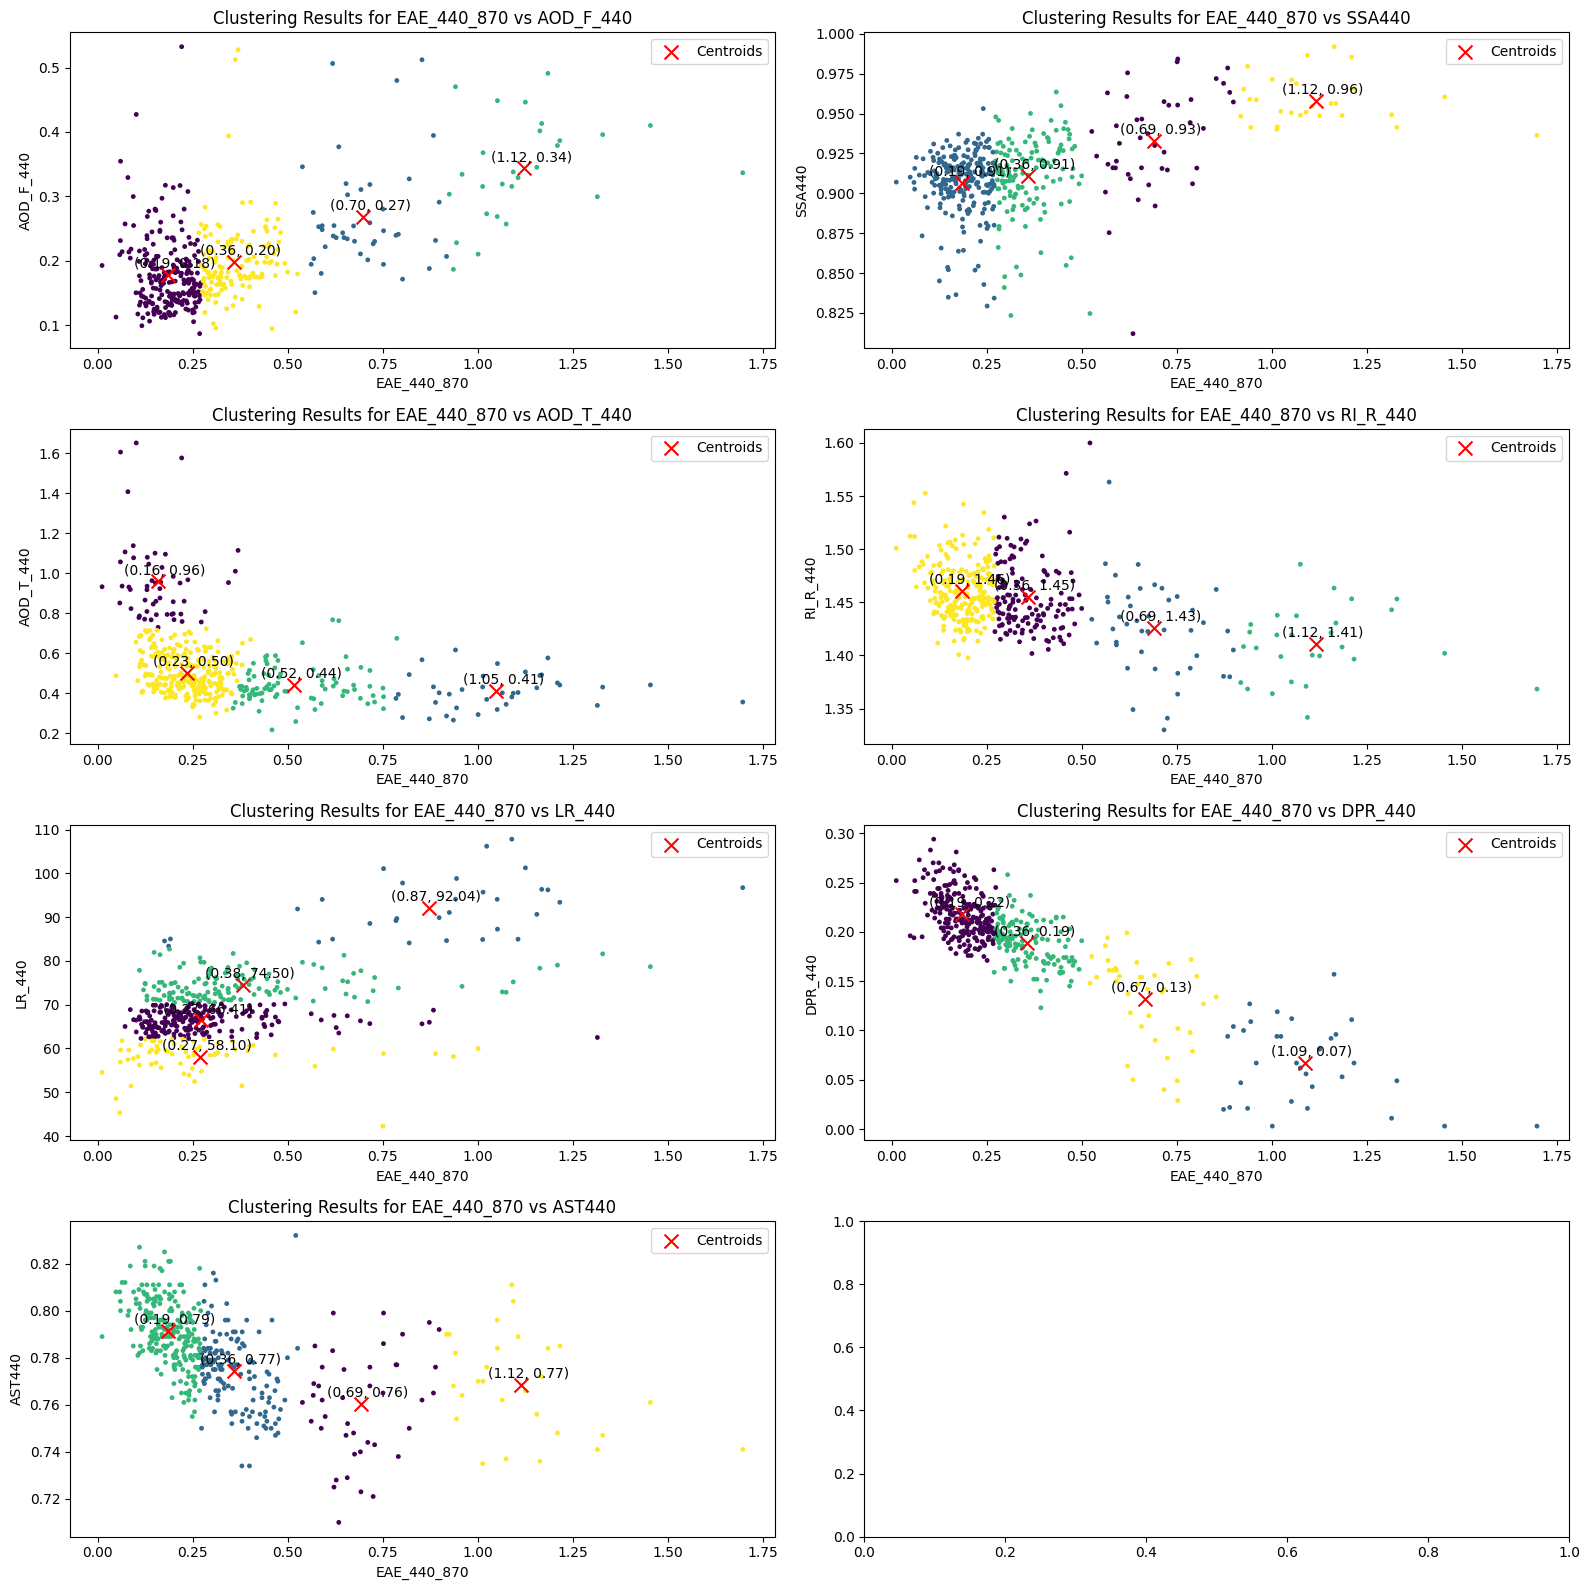

In [ ]:
import os
import numpy as np
import pandas as pd
import math
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Define the list of feature pairs
# feature_pairs = [('EAE_440_870','AOD_F_440'),
#                  ('EAE_440_870','SSA440'),
#                  ('EAE_440_870','AOD_T_440'),
#                  ('EAE_440_870','RI_R_440'),
#                  ('EAE_440_870','AAE_440_870'),
#                  ('EAE_440_870','DPR_440'),
#                  ('EAE_440_870','AST440')]

feature_pairs = [('EAE','AOD04'),
                 ('EAE','SSA04'),
                 ('EAE','ASY04'),
                 ('EAE','Cr04'),
                 ('EAE','FMF')]

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 2, figsize=(16, 16))

# Flatten the 2D array of subplots for easy indexing
axes = axes.flatten()
original_data = DATA

# Dictionary to store centroids
centroids_dict = {}

# Perform clustering for each feature pair
for i, (feature_x, feature_y) in enumerate(feature_pairs):
    # Extract features from the original dataset
    X = original_data[[feature_x, feature_y]].dropna()

    # Perform KMeans clustering on the selected features
    num_clusters = 4  # Adjust the number of clusters as needed
    kmeans = KMeans(n_clusters=num_clusters, random_state=2)
    kmeans.fit(X)
    cluster_predictions = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Store the centroid values in the dictionary
    centroids_dict[(feature_x, feature_y)] = centroids

    # # Print the centroid values
    # print(f'Centroids for {feature_x} vs {feature_y}:')
    # print(centroids)

    # Visualize the clustering results
    scatter = axes[i].scatter(X[feature_x], X[feature_y], c=cluster_predictions, s=6, cmap='viridis')
    axes[i].scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroids')

    # Annotate the centroids
    for j, (cx, cy) in enumerate(centroids):
        axes[i].annotate(f'({cx:.2f}, {cy:.2f})', (cx, cy), textcoords='offset points', xytext=(5,5), ha='center')

    axes[i].set_title(f'Clustering Results for {feature_x} vs {feature_y}')
    axes[i].set_xlabel(feature_x)
    axes[i].set_ylabel(feature_y)
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

# # Print the dictionary of centroids
# print("All centroids:")
# for key, value in centroids_dict.items():
#     print(f'{key}: {value}')


NameError: name 'original_data' is not defined

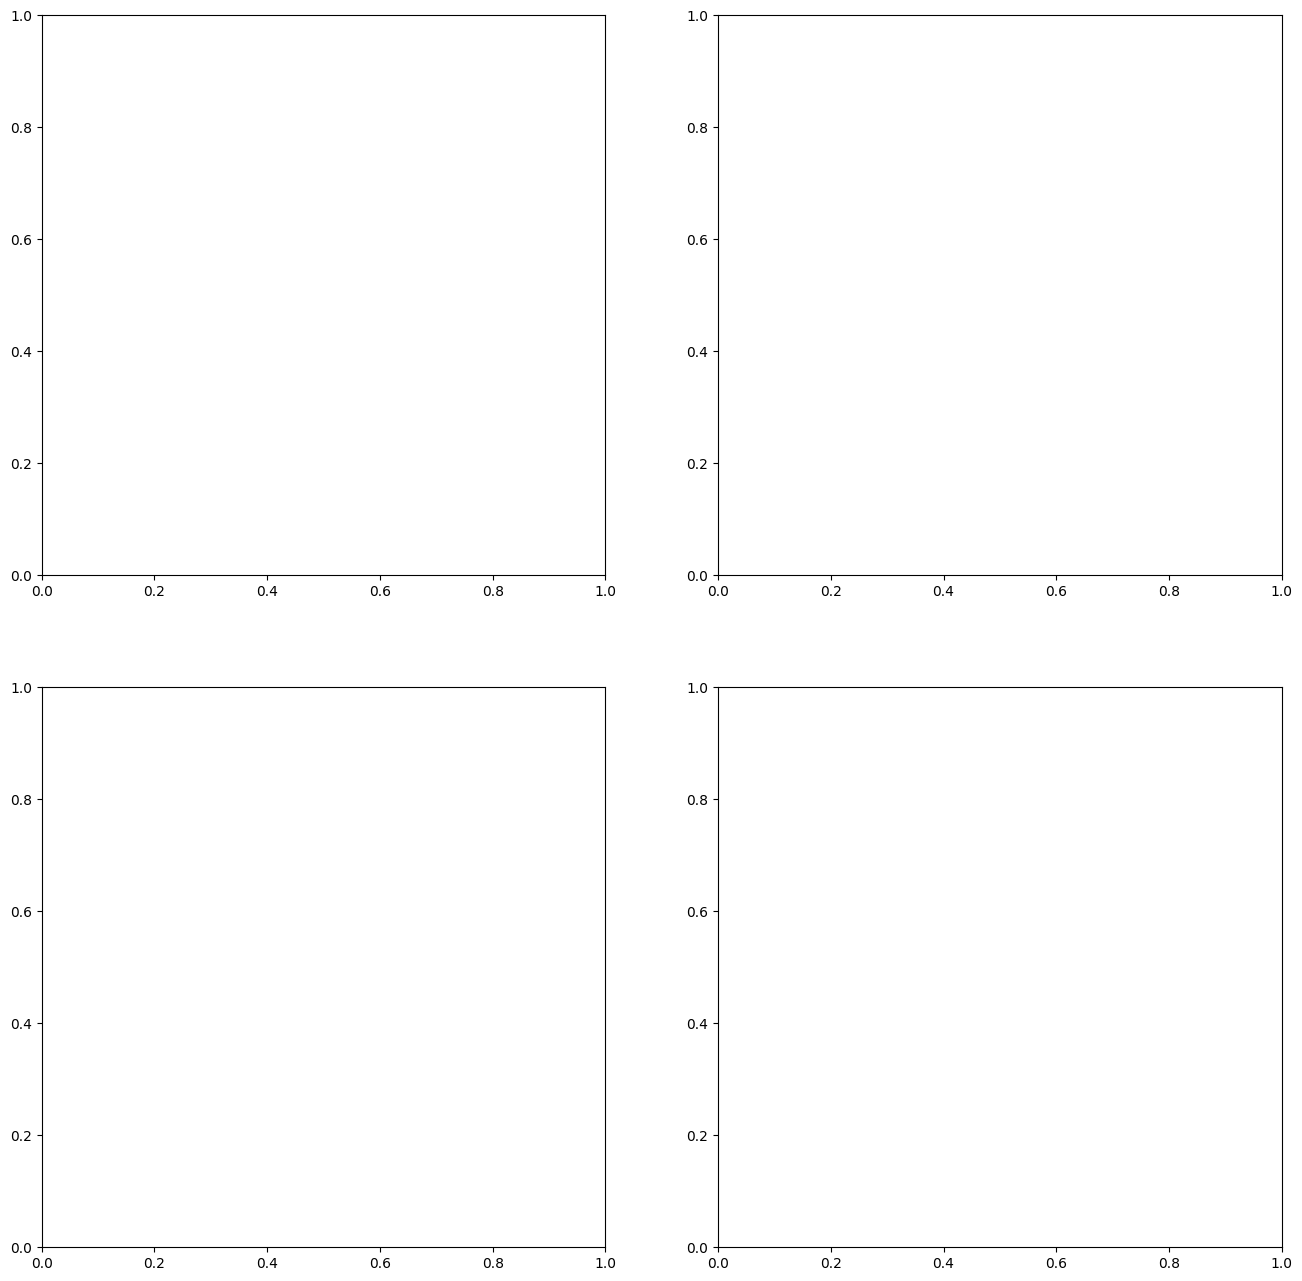

In [ ]:
import os
import numpy as np
import pandas as pd
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# # Define the list of feature pairs
# feature_pairs = [#('EAE_440_870','AOD_F_440'),
#                  ('EAE_440_870','SSA440'),
#                  #('EAE_440_870','AOD_T_440'),
#                  #('EAE_440_870','RI_R_440'),
#                  ('EAE_440_870','AAE_440_870'),
#                  ('EAE_440_870','DPR_440'),
#                  ('EAE_440_870','AST440')]
feature_pairs = [('EAE','AOD04'),
                 ('EAE','SSA04'),
                 ('EAE','ASY04'),
                 ('EAE','Cr04'),
                 ('EAE','FMF')]

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Flatten the 2D array of subplots for easy indexing
axes = axes.flatten()
original_data = DATA  # Replace with your actual data

# Dictionary to store centroids
centroids_dict = {}
cluster_predictions=("/content/drive/MyDrive/Calculated_data3/cluster_prediction.csv")
# Function to calculate cluster percentages
def calculate_cluster_percentages(cluster_predictions):
    """
    Calculates the percentage of each cluster in the data.

    Args:
        cluster_predictions: A numpy array containing cluster labels for each data point.

    Returns:
        A dictionary where keys are cluster labels and values are percentages.
    """
    unique_clusters, counts = np.unique(cluster_predictions, return_counts=True)
    total_points = len(cluster_predictions)
    percentages = (counts / total_points) * 100
    return dict(zip(unique_clusters, percentages))

# Perform clustering for each feature pair
for i, (feature_x, feature_y) in enumerate(feature_pairs):
    # Extract features from the original dataset
    X = original_data[[feature_x, feature_y]].dropna()

    # Perform KMeans clustering on the selected features
    num_clusters = 4  # Adjust the number of clusters as needed
    kmeans = KMeans(n_clusters=num_clusters, random_state=2)
    kmeans.fit(X)
    cluster_predictions = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Store the centroid values in the dictionary
    centroids_dict[(feature_x, feature_y)] = centroids

    # Calculate cluster percentages
    cluster_percentages = calculate_cluster_percentages(cluster_predictions)

    # Visualize the clustering results
    scatter = axes[i].scatter(X[feature_x], X[feature_y], c=cluster_predictions, s=6, cmap='viridis')
    axes[i].scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroids')

    for j, (cx, cy) in enumerate(centroids):
        axes[i].annotate(f'({cx:.2f}, {cy:.2f})', (cx, cy), textcoords='offset points', xytext=(5,5), ha='center')

    # Create custom legend labels with percentages
    legend_labels = [f'Cluster {label} ({percentage:.1f}%)' for label, percentage in cluster_percentages.items()]

    # Add legend to the plot
    axes[i].legend(scatter.legend_elements()[0], legend_labels)

    axes[i].set_title(f'Clustering Results for {feature_x} vs {feature_y}')
    axes[i].set_xlabel(feature_x)
    axes[i].set_ylabel(feature_y)

# Adjust layout
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

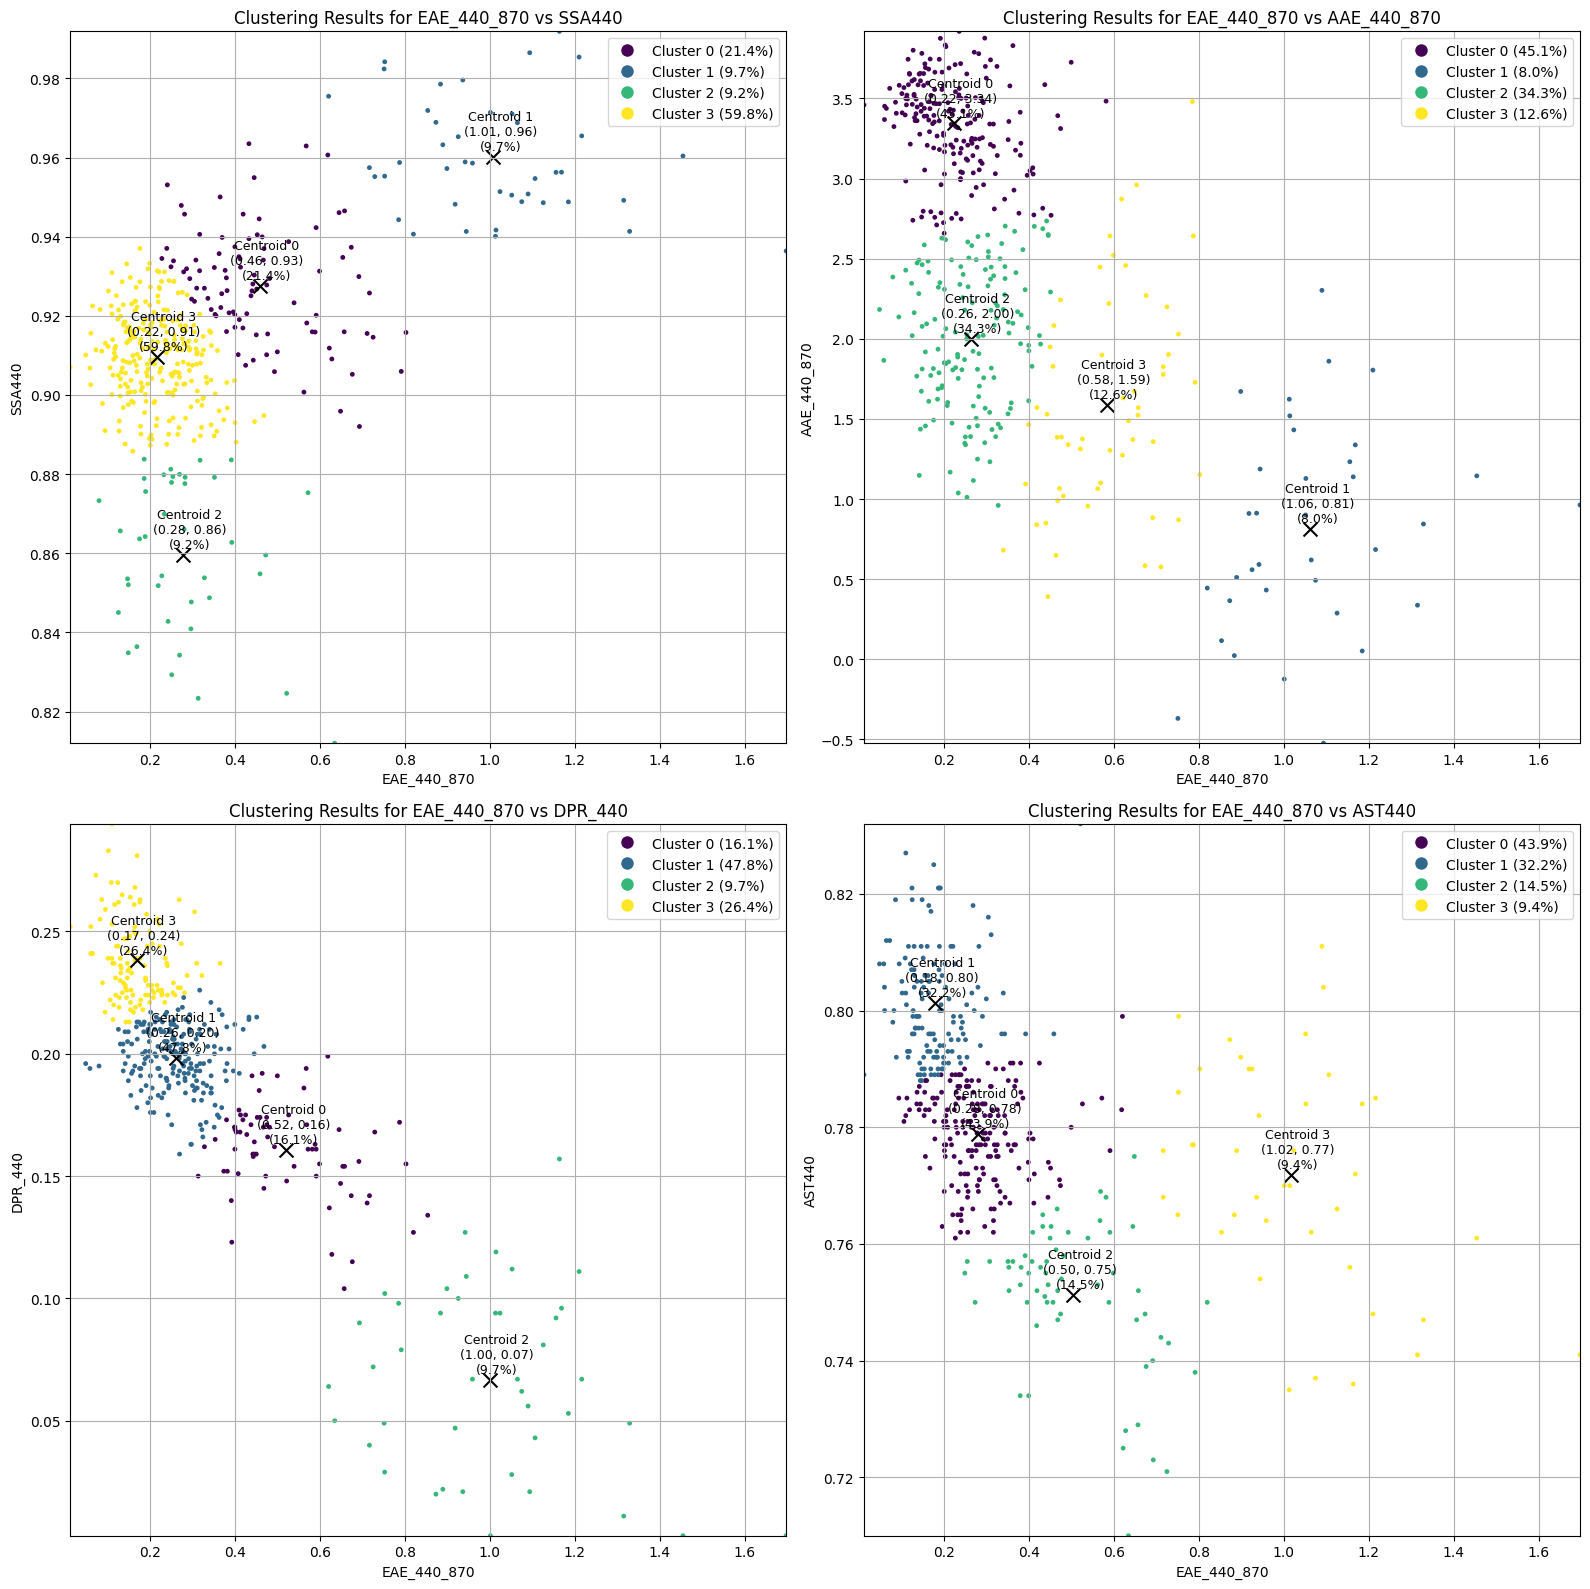

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the data
original_data = pd.read_csv("/content/drive/MyDrive/Clustering_data/Saada-inver_op.csv", delimiter=",")

# Define the list of feature pairs
feature_pairs = [
    ('EAE_440_870', 'SSA440'),
    ('EAE_440_870', 'AAE_440_870'),
    ('EAE_440_870', 'DPR_440'),
    ('EAE_440_870', 'AST440')
]

# Define colors for each cluster
num_clusters = 4
colors = plt.cm.viridis(np.linspace(0, 1, num_clusters))  # Use the 'viridis' colormap for consistency

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

# Function to calculate cluster percentages
def calculate_cluster_percentages(cluster_predictions):
    unique_clusters, counts = np.unique(cluster_predictions, return_counts=True)
    total_points = len(cluster_predictions)
    percentages = (counts / total_points) * 100
    return dict(zip(unique_clusters, percentages))

# Perform clustering for each feature pair
for i, (feature_x, feature_y) in enumerate(feature_pairs):
    try:
        X = original_data[[feature_x, feature_y]].dropna()
        X_scaled = StandardScaler().fit_transform(X)
    except KeyError:
        print(f"Features {feature_x} or {feature_y} are missing from the dataset.")
        continue

    kmeans = KMeans(n_clusters=num_clusters, random_state=2)
    kmeans.fit(X_scaled)
    cluster_predictions = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Calculate cluster percentages
    cluster_percentages = calculate_cluster_percentages(cluster_predictions)

    # Inverse transform centroids to original scale for accurate plotting
    scaler = StandardScaler().fit(X)  # Fit scaler on original data
    centroids_original = scaler.inverse_transform(centroids)

    # Determine axis limits
    x_min, x_max = X[feature_x].min(), X[feature_x].max()
    y_min, y_max = X[feature_y].min(), X[feature_y].max()

    # Visualize the clustering results with consistent colors
    scatter = axes[i].scatter(X[feature_x], X[feature_y], c=cluster_predictions, s=6, cmap='viridis')
    axes[i].scatter(centroids_original[:, 0], centroids_original[:, 1], marker='x', s=100, c='black', label='Centroids')

    # Annotate centroids with values and cluster percentages
    for j, (cx, cy) in enumerate(centroids_original):
        axes[i].annotate(f'Centroid {j}\n({cx:.2f}, {cy:.2f})\n({cluster_percentages.get(j, 0):.1f}%)',
                         (cx, cy), textcoords='offset points', xytext=(5,5), ha='center', fontsize=9, color='black')

    # Set axis limits
    axes[i].set_xlim(x_min, x_max)
    axes[i].set_ylim(y_min, y_max)

    # Create a custom legend with consistent colors
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[j], markersize=10) for j in range(num_clusters)]
    legend_labels = [f'Cluster {j} ({cluster_percentages.get(j, 0):.1f}%)' for j in range(num_clusters)]
    axes[i].legend(handles, legend_labels, loc='upper right')

    axes[i].set_title(f'Clustering Results for {feature_x} vs {feature_y}')
    axes[i].set_xlabel(feature_x)
    axes[i].set_ylabel(feature_y)
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the data
original_data = pd.read_csv("/content/drive/MyDrive/Clustering_data/Saada-inver_op.csv", delimiter=",")

# Define the list of feature pairs
feature_pairs = [
    ('EAE_440_870', 'SSA440'),
    ('EAE_440_870', 'AAE_440_870'),
    ('EAE_440_870', 'DPR_440'),
    ('EAE_440_870', 'AST440')
]

# Function to calculate cluster percentages
def calculate_cluster_percentages(cluster_predictions):
    unique_clusters, counts = np.unique(cluster_predictions, return_counts=True)
    total_points = len(cluster_predictions)
    percentages = (counts / total_points) * 100
    return dict(zip(unique_clusters, percentages))

# Loop through each feature pair
for feature_x, feature_y in feature_pairs:
    try:
        X = original_data[[feature_x, feature_y]].dropna()
    except KeyError:
        print(f"Features {feature_x} or {feature_y} are missing from the dataset.")
        continue

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform KMeans clustering
    num_clusters = 4
    kmeans = KMeans(n_clusters=num_clusters, random_state=2)
    kmeans.fit(X_scaled)
    cluster_predictions = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Inverse transform centroids to original scale
    centroids_original = scaler.inverse_transform(centroids)

    # Calculate cluster percentages
    cluster_percentages = calculate_cluster_percentages(cluster_predictions)

    # Print centroids and their corresponding percentages for the current feature pair
    print(f"\nCentroid Values and Percentages for {feature_x} vs {feature_y}:")
    for i, (cx, cy) in enumerate(centroids_original):
        percentage = cluster_percentages.get(i, 0)
        print(f"Cluster {i}: Centroid ({cx:.2f}, {cy:.2f}) - {percentage:.1f}% of data points")



Centroid Values and Percentages for EAE_440_870 vs SSA440:
Cluster 0: Centroid (0.46, 0.93) - 21.4% of data points
Cluster 1: Centroid (1.01, 0.96) - 9.7% of data points
Cluster 2: Centroid (0.28, 0.86) - 9.2% of data points
Cluster 3: Centroid (0.22, 0.91) - 59.8% of data points

Centroid Values and Percentages for EAE_440_870 vs AAE_440_870:
Cluster 0: Centroid (0.22, 3.34) - 45.1% of data points
Cluster 1: Centroid (1.06, 0.81) - 8.0% of data points
Cluster 2: Centroid (0.26, 2.00) - 34.3% of data points
Cluster 3: Centroid (0.58, 1.59) - 12.6% of data points

Centroid Values and Percentages for EAE_440_870 vs DPR_440:
Cluster 0: Centroid (0.52, 0.16) - 16.1% of data points
Cluster 1: Centroid (0.26, 0.20) - 47.8% of data points
Cluster 2: Centroid (1.00, 0.07) - 9.7% of data points
Cluster 3: Centroid (0.17, 0.24) - 26.4% of data points

Centroid Values and Percentages for EAE_440_870 vs AST440:
Cluster 0: Centroid (0.28, 0.78) - 43.9% of data points
Cluster 1: Centroid (0.18, 0.8

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Available columns in original_data: Index(['AOD01', ' AOD02', ' AOD03', ' AOD04', ' AOD05', ' SSA01', ' SSA02',
       ' SSA03', ' SSA04', ' SSA05', ' ASY01', ' ASY02', ' ASY03', ' ASY04',
       ' ASY05', ' Cr01', ' Cr02', ' Cr03', ' Cr04', ' Cr05', ' EAE', ' FMF'],
      dtype='object')


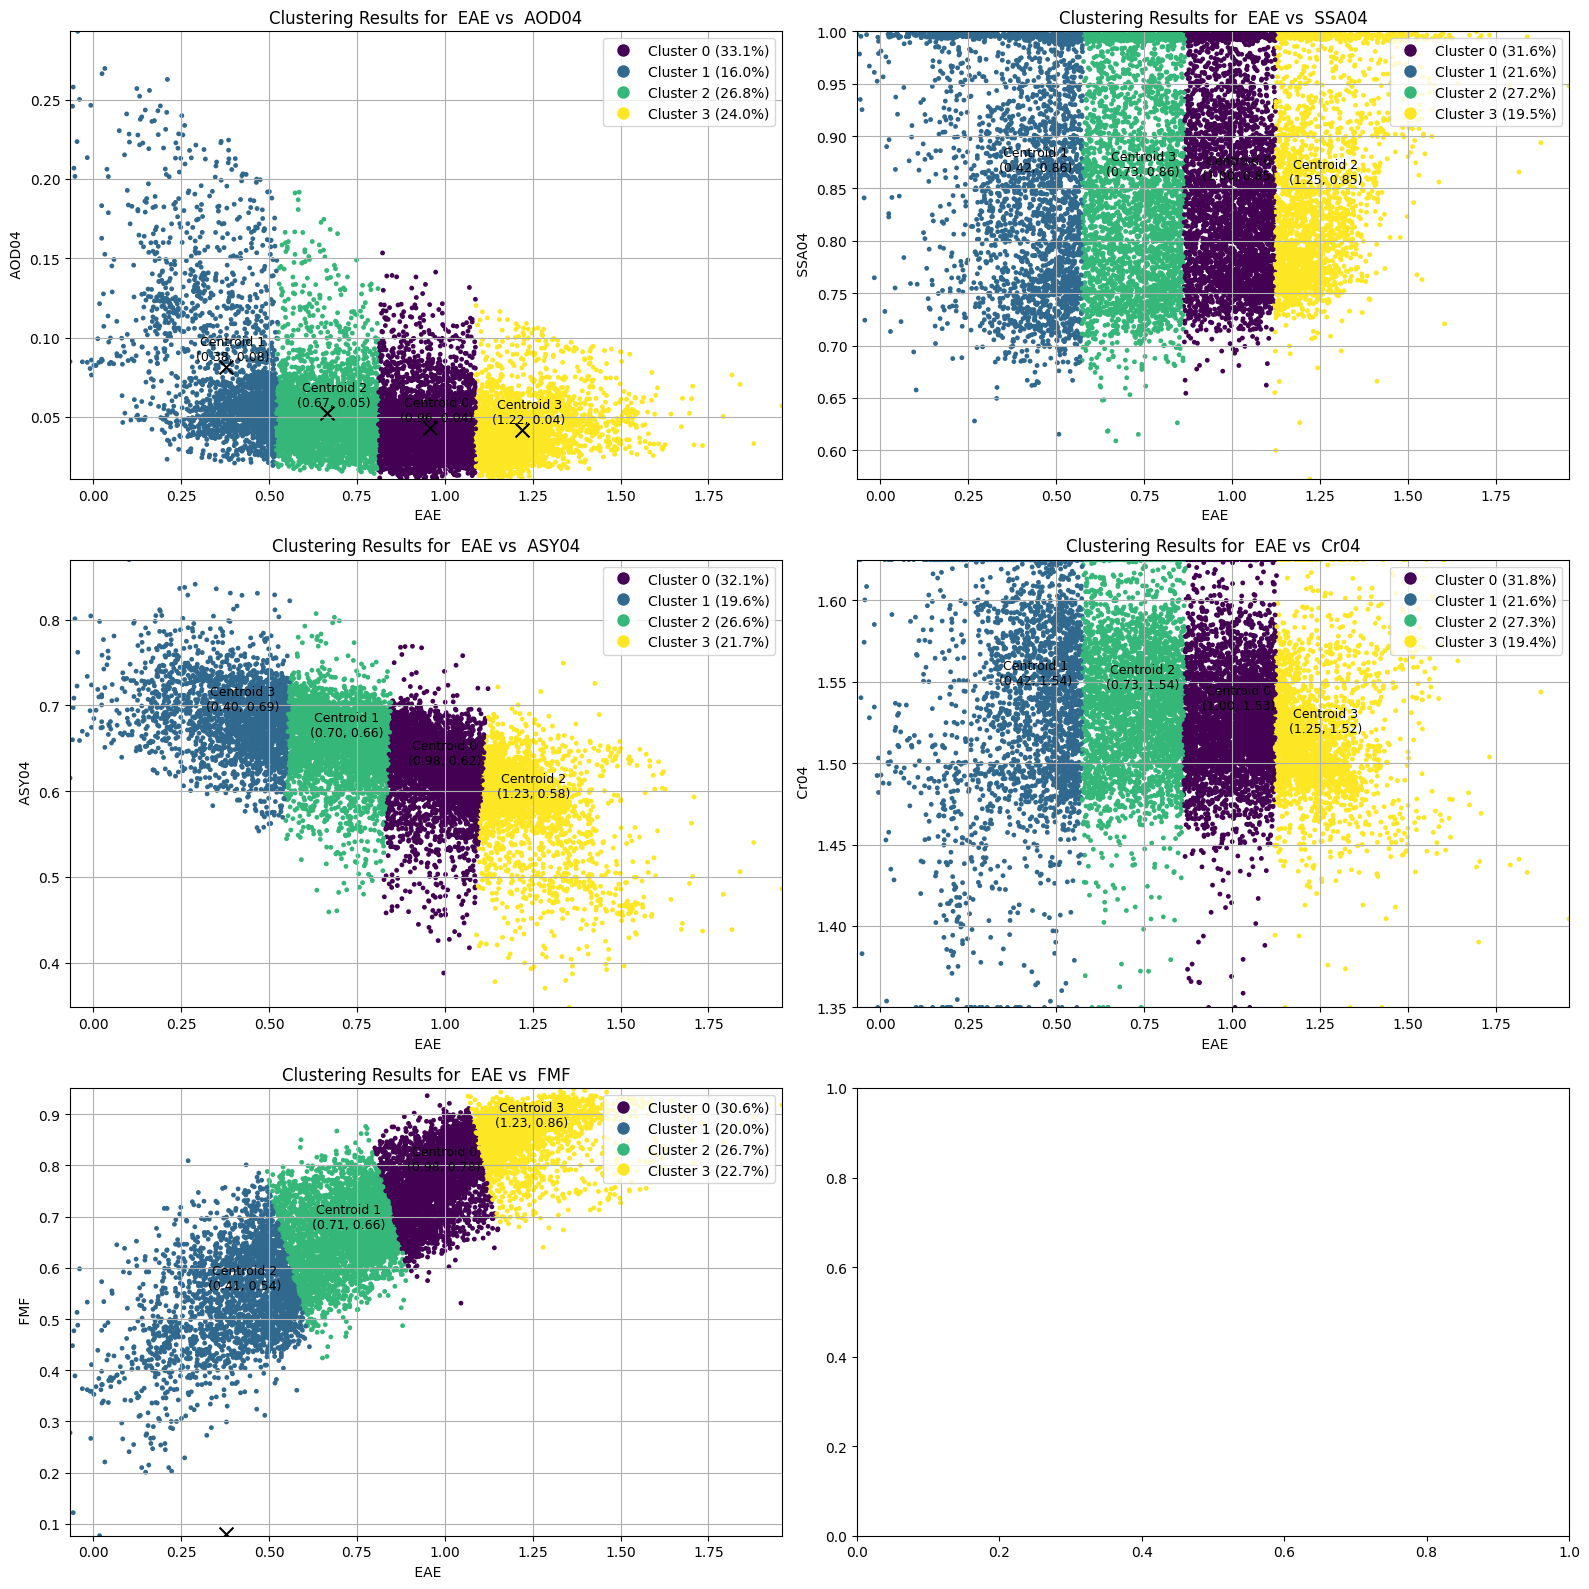

Centroid Values:
Cluster 0: Centroid (0.98, 0.78)
Cluster 1: Centroid (0.71, 0.66)
Cluster 2: Centroid (0.41, 0.54)
Cluster 3: Centroid (1.23, 0.86)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Load the data
original_data = pd.read_csv("/content/drive/MyDrive/Clustering_data/Instant_sorted-op copy.csv", delimiter=",")
# Define the list of feature pairs
# feature_pairs = [
#     ('EAE_440_870', 'SSA440'),
#     #('EAE_440_870', 'AAE_440_870'),  # We might adapt clustering for this pair
#     ('EAE_440_870', 'DPR_440'),
#     ('EAE_440_870', 'AST440'),
#     ('EAE_440_870', 'RI_R_440')
#     #RI_R_440
# ]
feature_pairs = [('EAE','AOD04'),
                 ('EAE','SSA04'),
                 ('EAE','ASY04'),
                 ('EAE','Cr04'),
                 ('EAE','FMF')]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

# Define a colormap for consistent colors
colors = plt.cm.viridis(np.linspace(0, 1, 4))

# Perform initial clustering on the first pair of features
initial_feature_x, initial_feature_y = feature_pairs[0]
X_initial = original_data[[initial_feature_x, initial_feature_y]].dropna()
kmeans_initial = KMeans(n_clusters=4, random_state=2)
kmeans_initial.fit(X_initial)
initial_centroids = kmeans_initial.cluster_centers_

# Function to calculate cluster percentages
def calculate_cluster_percentages(cluster_predictions):
    unique_clusters, counts = np.unique(cluster_predictions, return_counts=True)
    total_points = len(cluster_predictions)
    percentages = (counts / total_points) * 100
    return dict(zip(unique_clusters, percentages))

# Dictionary to store centroids and cluster labels for each plot
centroids_dict = {}
centroids_dict[(initial_feature_x, initial_feature_y)] = (initial_centroids, kmeans_initial.labels_)

# Plot the first clustering result
axes[0].scatter(X_initial[initial_feature_x], X_initial[initial_feature_y], c=kmeans_initial.labels_, s=6, cmap='viridis')
axes[0].scatter(initial_centroids[:, 0], initial_centroids[:, 1], marker='x', s=100, c='black', label='Centroids')
for j, (cx, cy) in enumerate(initial_centroids):
    axes[0].annotate(f'Centroid {j}\n({cx:.2f}, {cy:.2f})', (cx, cy), textcoords='offset points', xytext=(5,5), ha='center', fontsize=9, color='black')
axes[0].set_xlim(X_initial[initial_feature_x].min(), X_initial[initial_feature_x].max())
axes[0].set_ylim(X_initial[initial_feature_y].min(), X_initial[initial_feature_y].max())
cluster_percentages_initial = calculate_cluster_percentages(kmeans_initial.labels_)
legend_labels_initial = [f'Cluster {j} ({cluster_percentages_initial.get(j, 0):.1f}%)' for j in range(4)]
handles_initial = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[j], markersize=10) for j in range(4)]
axes[0].legend(handles_initial, legend_labels_initial, loc='upper right')
axes[0].set_title(f'Clustering Results for {initial_feature_x} vs {initial_feature_y}')
axes[0].set_xlabel(initial_feature_x)
axes[0].set_ylabel(initial_feature_y)
axes[0].grid(True)

# Perform clustering on remaining feature pairs and match labels
for i, (feature_x, feature_y) in enumerate(feature_pairs[1:], 1):
    X = original_data[[feature_x, feature_y]].dropna()

    # Adjust number of clusters based on feature pair (use 2 clusters for AAE, if needed)
    num_clusters = 2 if feature_x == 'AAE_440_870' else 4
    kmeans = KMeans(n_clusters=num_clusters, random_state=2)
    kmeans.fit(X)

    # Match new centroids to the initial centroids
    new_centroids = kmeans.cluster_centers_
    closest, _ = pairwise_distances_argmin_min(new_centroids, initial_centroids[:num_clusters])  # Only compare to available centroids

    # Re-label clusters based on the closest centroids
    relabeled_clusters = np.zeros_like(kmeans.labels_)
    for new_label, old_label in enumerate(closest):
        relabeled_clusters[kmeans.labels_ == new_label] = old_label

    # Store centroids and re-labeled clusters
    centroids_dict[(feature_x, feature_y)] = (new_centroids, relabeled_clusters)

    # Check for empty clusters and handle them
    unique_labels = np.unique(relabeled_clusters)
    if len(unique_labels) < num_clusters:
        print(f"Warning: Only {len(unique_labels)} clusters found for {feature_x} vs {feature_y}.")

    # Visualization with consistent colors
    scatter = axes[i].scatter(X[feature_x], X[feature_y], c=relabeled_clusters, s=6, cmap='viridis')
    axes[i].scatter(initial_centroids[:, 0], initial_centroids[:, 1], marker='x', s=100, c='black', label='Centroids')

    # Annotate centroids and set axis limits
    for j, (cx, cy) in enumerate(new_centroids):
        if j in unique_labels:  # Only annotate non-empty clusters
            axes[i].annotate(f'Centroid {j}\n({cx:.2f}, {cy:.2f})', (cx, cy), textcoords='offset points', xytext=(5,5), ha='center', fontsize=9, color='black')

    # Set axis limits and add a legend
    axes[i].set_xlim(X[feature_x].min(), X[feature_x].max())
    axes[i].set_ylim(X[feature_y].min(), X[feature_y].max())
    cluster_percentages = calculate_cluster_percentages(relabeled_clusters)
    legend_labels = [f'Cluster {label} ({cluster_percentages.get(label, 0):.1f}%)' for label in unique_labels]
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10) for label in unique_labels]
    axes[i].legend(handles, legend_labels, loc='upper right')

    axes[i].set_title(f'Clustering Results for {feature_x} vs {feature_y}')
    axes[i].set_xlabel(feature_x)
    axes[i].set_ylabel(feature_y)
    axes[i].grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex


Centroid Values and Percentages for EAE_440_870 vs SSA440:
Cluster 0: Centroid (0.19, 0.91) - 51.5% of data points
Cluster 1: Centroid (0.69, 0.93) - 9.9% of data points
Cluster 2: Centroid (0.36, 0.91) - 32.2% of data points
Cluster 3: Centroid (1.12, 0.96) - 6.4% of data points

Centroid Values and Percentages for EAE_440_870 vs DPR_440:
Cluster 0: Centroid (0.36, 0.19) - 51.5% of data points
Cluster 1: Centroid (1.09, 0.07) - 9.2% of data points
Cluster 2: Centroid (0.19, 0.22) - 32.0% of data points
Cluster 3: Centroid (0.67, 0.13) - 7.4% of data points

Centroid Values and Percentages for EAE_440_870 vs AST440:
Cluster 0: Centroid (0.19, 0.79) - 51.7% of data points
Cluster 1: Centroid (0.69, 0.76) - 9.7% of data points
Cluster 2: Centroid (0.36, 0.77) - 32.2% of data points
Cluster 3: Centroid (1.12, 0.77) - 6.4% of data points

Centroid Values and Percentages for EAE_440_870 vs RI_R_440:
Cluster 0: Centroid (0.19, 1.46) - 51.5% of data points
Cluster 1: Centroid (0.69, 1.43) - 

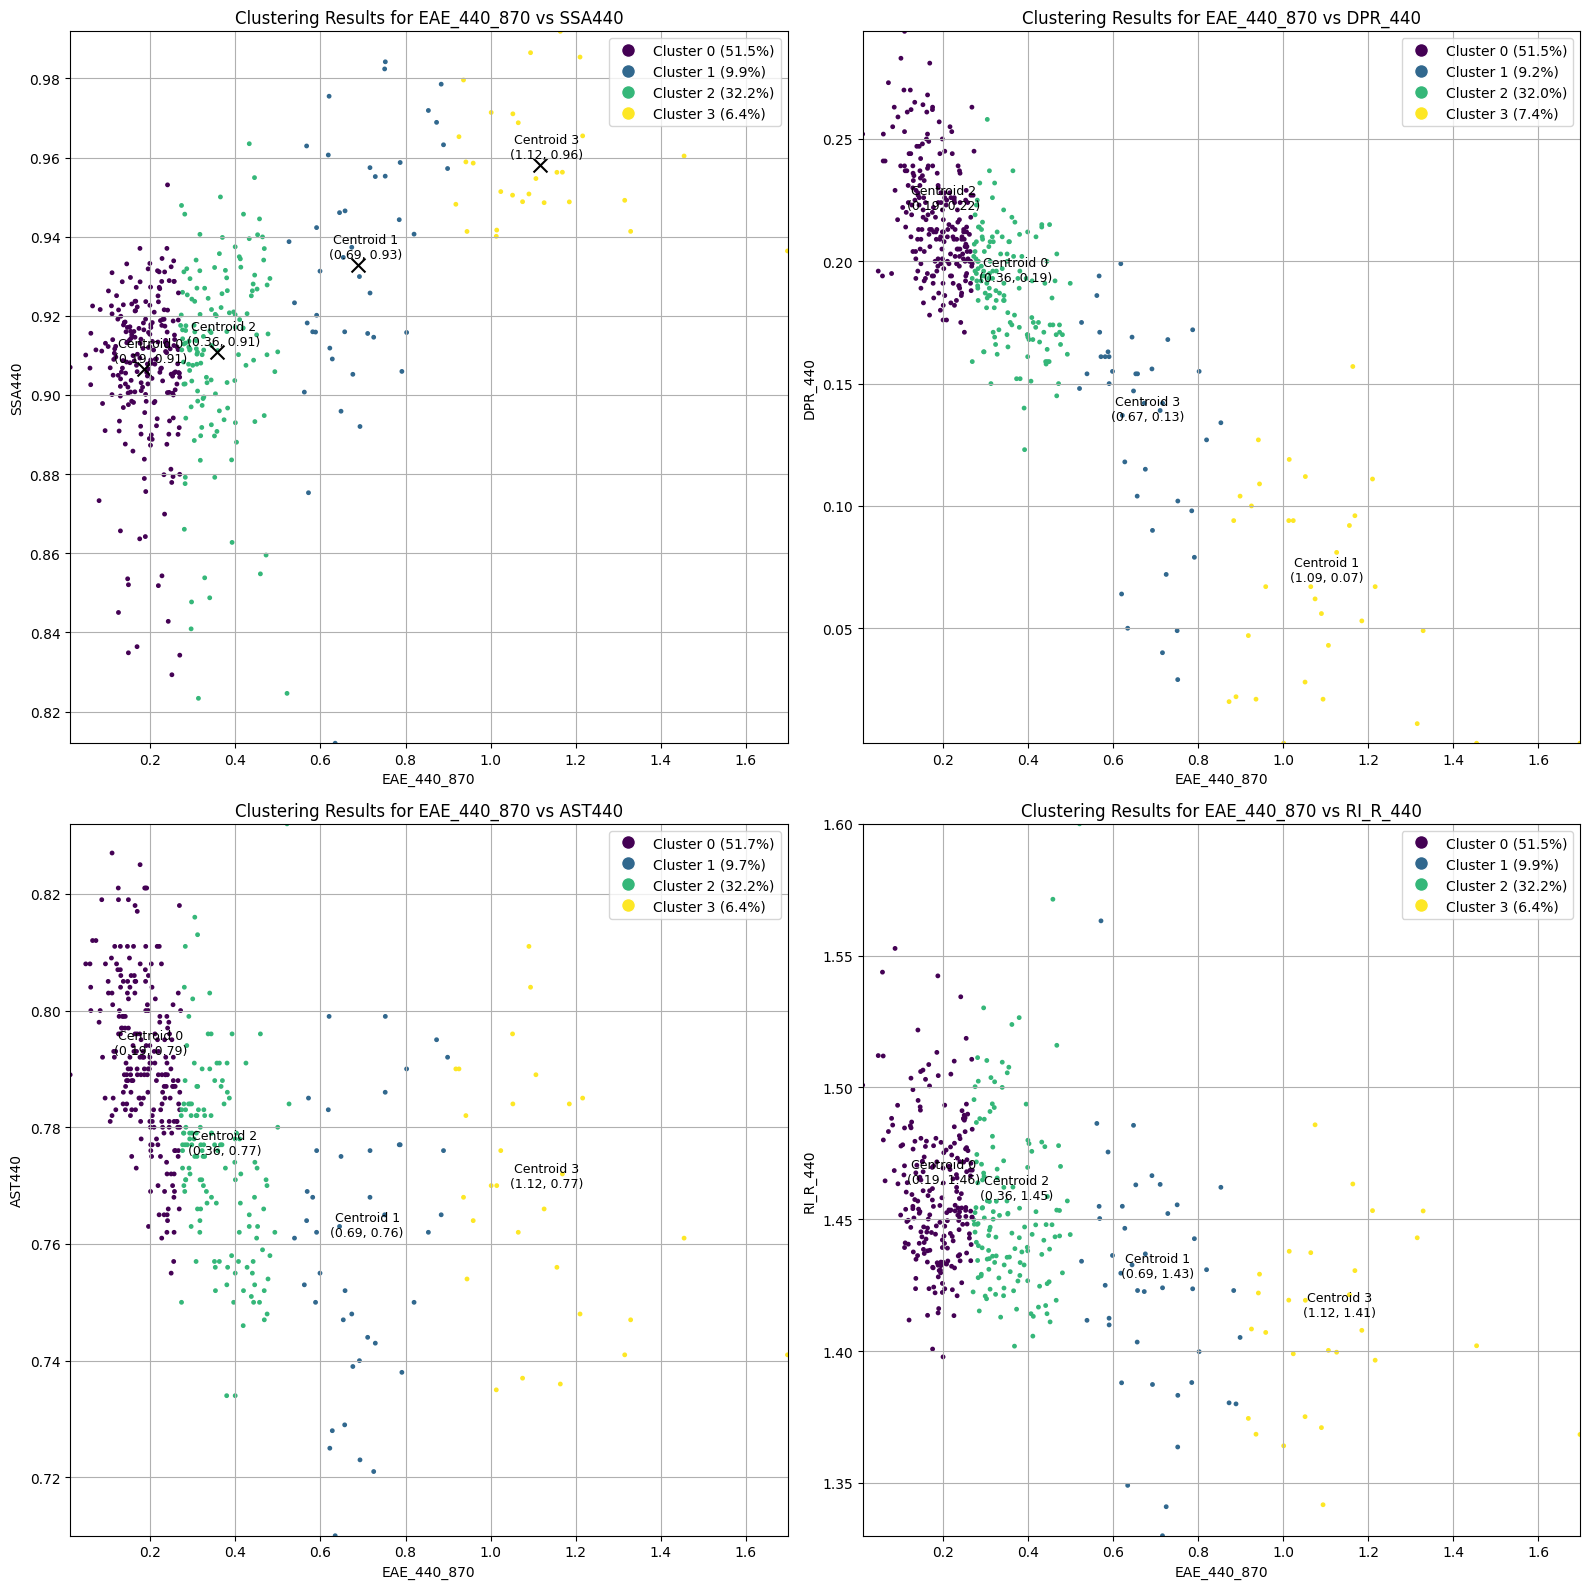

In [ ]:
#showing the same percentage for same colour cluster

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Load the data
original_data = pd.read_csv("/content/drive/MyDrive/Clustering_data/Saada-inver_op.csv", delimiter=",")

# Define the list of feature pairs
feature_pairs = [
    ('EAE_440_870', 'SSA440'),
    #('EAE_440_870', 'AAE_440_870'),  # We might adapt clustering for this pair
    ('EAE_440_870', 'DPR_440'),
    ('EAE_440_870', 'AST440'),
    ('EAE_440_870', 'RI_R_440')
    #RI_R_440
]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

# Define a colormap for consistent colors
colors = plt.cm.viridis(np.linspace(0, 1, 4))

# Perform initial clustering on the first pair of features
initial_feature_x, initial_feature_y = feature_pairs[0]
X_initial = original_data[[initial_feature_x, initial_feature_y]].dropna()
kmeans_initial = KMeans(n_clusters=4, random_state=2)
kmeans_initial.fit(X_initial)
initial_centroids = kmeans_initial.cluster_centers_

# Function to calculate cluster percentages
def calculate_cluster_percentages(cluster_predictions):
    unique_clusters, counts = np.unique(cluster_predictions, return_counts=True)
    total_points = len(cluster_predictions)
    percentages = (counts / total_points) * 100
    return dict(zip(unique_clusters, percentages))

# Dictionary to store centroids and cluster labels for each plot
centroids_dict = {}
centroids_dict[(initial_feature_x, initial_feature_y)] = (initial_centroids, kmeans_initial.labels_)

# Print centroid values and percentages for the initial feature pair
print(f"\nCentroid Values and Percentages for {initial_feature_x} vs {initial_feature_y}:")
cluster_percentages_initial = calculate_cluster_percentages(kmeans_initial.labels_)
for j, (cx, cy) in enumerate(initial_centroids):
    percentage = cluster_percentages_initial.get(j, 0)
    print(f"Cluster {j}: Centroid ({cx:.2f}, {cy:.2f}) - {percentage:.1f}% of data points")

# Plot the first clustering result
axes[0].scatter(X_initial[initial_feature_x], X_initial[initial_feature_y], c=kmeans_initial.labels_, s=6, cmap='viridis')
axes[0].scatter(initial_centroids[:, 0], initial_centroids[:, 1], marker='x', s=100, c='black', label='Centroids')
for j, (cx, cy) in enumerate(initial_centroids):
    axes[0].annotate(f'Centroid {j}\n({cx:.2f}, {cy:.2f})', (cx, cy), textcoords='offset points', xytext=(5,5), ha='center', fontsize=9, color='black')
axes[0].set_xlim(X_initial[initial_feature_x].min(), X_initial[initial_feature_x].max())
axes[0].set_ylim(X_initial[initial_feature_y].min(), X_initial[initial_feature_y].max())
legend_labels_initial = [f'Cluster {j} ({cluster_percentages_initial.get(j, 0):.1f}%)' for j in range(4)]
handles_initial = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[j], markersize=10) for j in range(4)]
axes[0].legend(handles_initial, legend_labels_initial, loc='upper right')
axes[0].set_title(f'Clustering Results for {initial_feature_x} vs {initial_feature_y}')
axes[0].set_xlabel(initial_feature_x)
axes[0].set_ylabel(initial_feature_y)
axes[0].grid(True)

# Perform clustering on remaining feature pairs and match labels
for i, (feature_x, feature_y) in enumerate(feature_pairs[1:], 1):
    X = original_data[[feature_x, feature_y]].dropna()

    # Adjust number of clusters based on feature pair (use 2 clusters for AAE, if needed)
    num_clusters = 2 if feature_x == 'AAE_440_870' else 4
    kmeans = KMeans(n_clusters=num_clusters, random_state=2)
    kmeans.fit(X)

    # Match new centroids to the initial centroids
    new_centroids = kmeans.cluster_centers_
    closest, _ = pairwise_distances_argmin_min(new_centroids, initial_centroids[:num_clusters])  # Only compare to available centroids

    # Re-label clusters based on the closest centroids
    relabeled_clusters = np.zeros_like(kmeans.labels_)
    for new_label, old_label in enumerate(closest):
        relabeled_clusters[kmeans.labels_ == new_label] = old_label

    # Store centroids and re-labeled clusters
    centroids_dict[(feature_x, feature_y)] = (new_centroids, relabeled_clusters)

    # Print centroid values and percentages for each feature pair
    print(f"\nCentroid Values and Percentages for {feature_x} vs {feature_y}:")
    cluster_percentages = calculate_cluster_percentages(relabeled_clusters)
    for j, (cx, cy) in enumerate(new_centroids):
        percentage = cluster_percentages.get(j, 0)
        print(f"Cluster {j}: Centroid ({cx:.2f}, {cy:.2f}) - {percentage:.1f}% of data points")

    # Check for empty clusters and handle them
    unique_labels = np.unique(relabeled_clusters)
    if len(unique_labels) < num_clusters:
        print(f"Warning: Only {len(unique_labels)} clusters found for {feature_x} vs {feature_y}.")

    # Visualization with consistent colors
    scatter = axes[i].scatter(X[feature_x], X[feature_y], c=relabeled_clusters, s=6, cmap='viridis')
    axes[i].scatter(initial_centroids[:, 0], initial_centroids[:, 1], marker='x', s=100, c='black', label='Centroids')

    # Annotate centroids and set axis limits
    for j, (cx, cy) in enumerate(new_centroids):
        if j in unique_labels:  # Only annotate non-empty clusters
            axes[i].annotate(f'Centroid {j}\n({cx:.2f}, {cy:.2f})', (cx, cy), textcoords='offset points', xytext=(5,5), ha='center', fontsize=9, color='black')

    # Set axis limits and add a legend
    axes[i].set_xlim(X[feature_x].min(), X[feature_x].max())
    axes[i].set_ylim(X[feature_y].min(), X[feature_y].max())
    cluster_percentages = calculate_cluster_percentages(relabeled_clusters)
    legend_labels = [f'Cluster {label} ({cluster_percentages.get(label, 0):.1f}%)' for label in unique_labels]
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10) for label in unique_labels]
    axes[i].legend(handles, legend_labels, loc='upper right')

    axes[i].set_title(f'Clustering Results for {feature_x} vs {feature_y}')
    axes[i].set_xlabel(feature_x)
    axes[i].set_ylabel(feature_y)
    axes[i].grid(True)

plt.tight_layout()
plt.show()



Centroid Values and Percentages for  EAE vs  AOD04:
Cluster 0: Centroid (0.96, 0.04) - 33.1% of data points
Cluster 1: Centroid (0.67, 0.05) - 26.8% of data points
Cluster 2: Centroid (1.22, 0.04) - 24.0% of data points
Cluster 3: Centroid (0.38, 0.08) - 16.0% of data points

Centroid Values and Percentages for  EAE vs  SSA04:
Cluster 0: Centroid (1.00, 0.85) - 31.6% of data points
Cluster 1: Centroid (0.73, 0.86) - 27.2% of data points
Cluster 2: Centroid (0.42, 0.86) - 21.6% of data points
Cluster 3: Centroid (1.25, 0.85) - 19.5% of data points

Centroid Values and Percentages for  EAE vs  ASY04:
Cluster 0: Centroid (0.98, 0.62) - 32.1% of data points
Cluster 1: Centroid (0.70, 0.66) - 26.6% of data points
Cluster 2: Centroid (1.23, 0.58) - 21.7% of data points
Cluster 3: Centroid (0.40, 0.69) - 19.6% of data points

Centroid Values and Percentages for  EAE vs  Cr04:
Cluster 0: Centroid (1.00, 1.53) - 31.8% of data points
Cluster 1: Centroid (0.73, 1.54) - 27.3% of data points
Clust

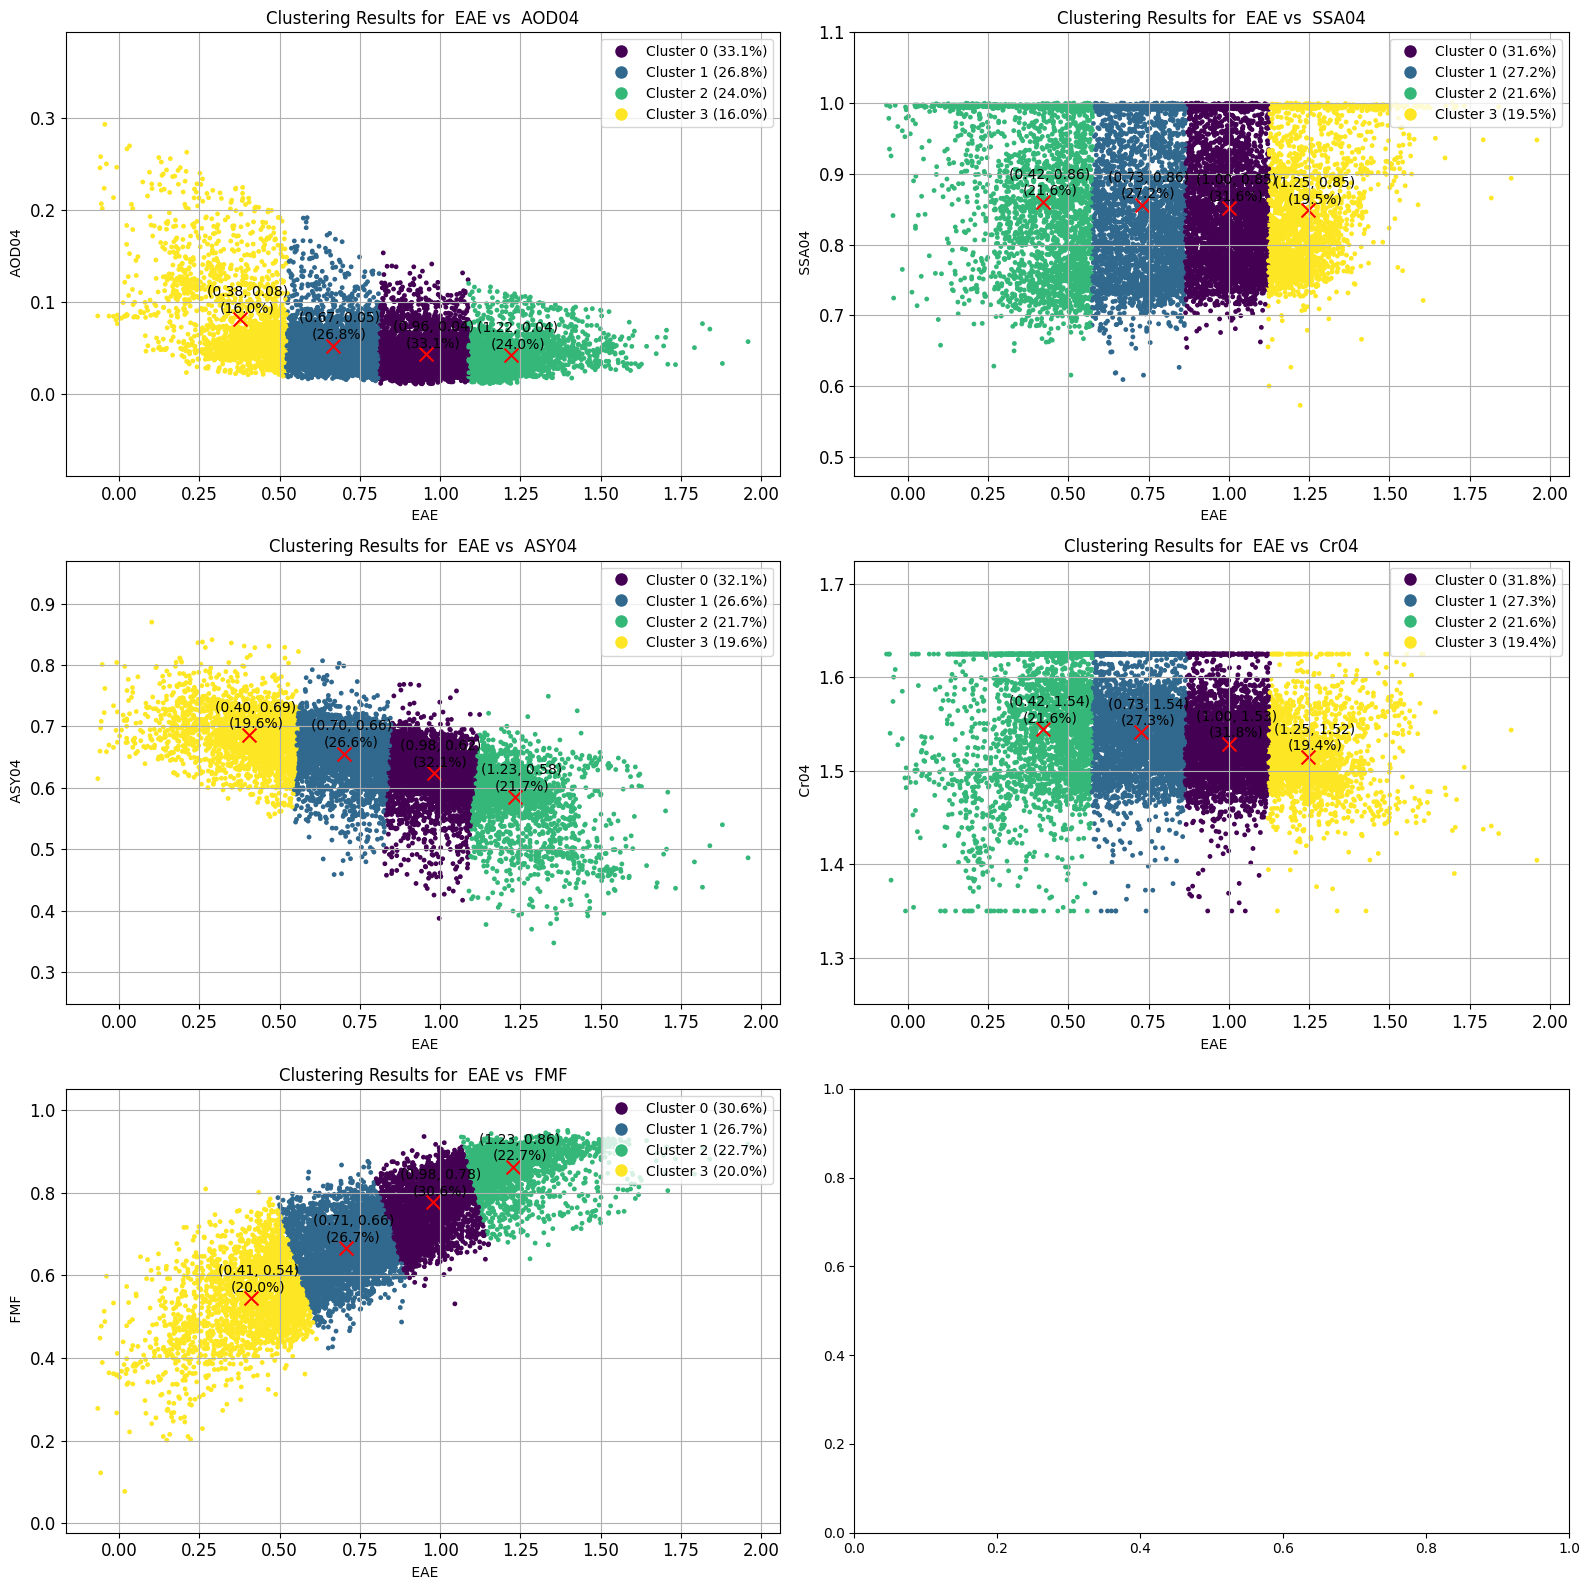

In [ ]:
#SADDA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Load the data
original_data = pd.read_csv("/content/drive/MyDrive/Clustering_data/Saada-inver_op.csv", delimiter=",")

# Define the list of feature pairs
feature_pairs = [
    ('EAE_440_870', 'SSA440'),
    ('EAE_440_870', 'AOD_F_440'),
    ('EAE_440_870', 'AAE_440_870'),
    ('EAE_440_870', 'DPR_440'),
    ('EAE_440_870', 'AST440'),
    ('EAE_440_870', 'RI_R_440')
]

# Create a 4x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()

# Define a colormap for consistent colors
colors = plt.cm.viridis(np.linspace(0, 1, 4))

# Function to calculate cluster percentages
def calculate_cluster_percentages(cluster_predictions):
    unique_clusters, counts = np.unique(cluster_predictions, return_counts=True)
    total_points = len(cluster_predictions)
    percentages = (counts / total_points) * 100
    return dict(zip(unique_clusters, percentages))

# Function to handle empty clusters
def handle_empty_clusters(kmeans, X, num_clusters):
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    unique_labels = np.unique(labels)
    if len(unique_labels) < num_clusters:
        # If there are empty clusters, reassign to nearest cluster
        distances = pairwise_distances_argmin_min(centroids, centroids)
        for i in range(num_clusters):
            if i not in unique_labels:
                # Find the closest existing centroid
                closest_centroid = np.argmin(distances[0])
                # Assign all points to the nearest existing centroid
                labels[labels == i] = closest_centroid
        kmeans.labels_ = labels
        centroids = kmeans.cluster_centers_
    return centroids, labels

# Function to reorder clusters based on percentage
def reorder_clusters(centroids, labels):
    percentages = calculate_cluster_percentages(labels)
    sorted_clusters = sorted(percentages.items(), key=lambda x: -x[1])  # Sort by percentage, descending
    cluster_order = [cluster for cluster, _ in sorted_clusters]

    # Create a mapping from old label to new label
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(cluster_order)}

    # Reassign labels based on the new order
    new_labels = np.array([label_mapping[label] for label in labels])
    new_centroids = centroids[cluster_order]

    return new_centroids, new_labels

# Perform clustering on each feature pair
for i, (feature_x, feature_y) in enumerate(feature_pairs):
    # Ensure numeric data
    original_data[feature_x] = pd.to_numeric(original_data[feature_x], errors='coerce')
    original_data[feature_y] = pd.to_numeric(original_data[feature_y], errors='coerce')

    # Extract features and drop rows with non-numeric values
    X = original_data[[feature_x, feature_y]].dropna()

    # Perform KMeans clustering on the selected features
    num_clusters = 4  # Adjust the number of clusters as needed
    kmeans = KMeans(n_clusters=num_clusters, random_state=2)
    kmeans.fit(X)

    # Handle empty clusters
    centroids, labels = handle_empty_clusters(kmeans, X, num_clusters)

    # Reorder clusters based on percentage
    centroids, labels = reorder_clusters(centroids, labels)

    # Calculate cluster percentages
    cluster_percentages = calculate_cluster_percentages(labels)

    # Visualization with consistent colors
    scatter = axes[i].scatter(X[feature_x], X[feature_y], c=labels, s=6, cmap='viridis')
    axes[i].scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroids')

    # Annotate centroids with values and percentages
    for j, (cx, cy) in enumerate(centroids):
        percentage = cluster_percentages.get(j, 0)
        axes[i].annotate(f'({cx:.2f}, {cy:.2f})\n({percentage:.1f}%)', (cx, cy), textcoords='offset points', xytext=(5,5), ha='center')

    # Improve the readability of axis labels
    axes[i].tick_params(axis='both', labelsize=12)

    # Set axis limits for better visibility
    axes[i].set_xlim(X[feature_x].min() - 0.1, X[feature_x].max() + 0.1)
    axes[i].set_ylim(X[feature_y].min() - 0.1, X[feature_y].max() + 0.1)

    # Set title and labels
    axes[i].set_title(f'Clustering Results for {feature_x} vs {feature_y}')
    axes[i].set_xlabel(feature_x)
    axes[i].set_ylabel(feature_y)

    # Create a legend with percentages
    legend_labels = [f'Cluster {label} ({cluster_percentages.get(label, 0):.1f}%)' for label in range(num_clusters)]
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10) for label in range(num_clusters)]
    axes[i].legend(handles, legend_labels, loc='upper right')

    axes[i].grid(True)

        # Print centroid values and percentages
    print(f"\nCentroid Values and Percentages for {feature_x} vs {feature_y}:")
    for j, (cx, cy) in enumerate(centroids):
        percentage = cluster_percentages.get(j, 0)
        print(f"Cluster {j}: Centroid ({cx:.2f}, {cy:.2f}) - {percentage:.1f}% of data points")


plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Centroid Values and Percentages for EAE_440_870 vs SSA440:
Cluster 0: Centroid (1.34, 0.90) - 19.4% of data points
Cluster 1: Centroid (1.07, 0.89) - 20.1% of data points
Cluster 2: Centroid (0.71, 0.87) - 29.3% of data points
Cluster 3: Centroid (0.31, 0.87) - 31.1% of data points

Centroid Values and Percentages for EAE_440_870 vs AOD_F_440:
Cluster 0: Centroid (0.36, 0.23) - 24.6% of data points
Cluster 1: Centroid (0.87, 0.32) - 28.4% of data points
Cluster 2: Centroid (1.26, 1.03) - 5.8% of data points
Cluster 3: Centroid (1.27, 0.45) - 41.2% of data points


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Centroid Values and Percentages for EAE_440_870 vs AAE_440_870:
Cluster 0: Centroid (0.56, 1.91) - 10.3% of data points
Cluster 1: Centroid (1.11, 1.48) - 23.1% of data points
Cluster 2: Centroid (0.33, 3.00) - 39.4% of data points
Cluster 3: Centroid (1.23, 0.90) - 27.2% of data points

Centroid Values and Percentages for EAE_440_870 vs DPR_440:
Cluster 0: Centroid (0.31, 0.17) - 19.4% of data points
Cluster 1: Centroid (1.07, 0.07) - 19.9% of data points
Cluster 2: Centroid (1.34, 0.03) - 29.4% of data points
Cluster 3: Centroid (0.71, 0.10) - 31.4% of data points


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Centroid Values and Percentages for EAE_440_870 vs AST440:
Cluster 0: Centroid (0.31, 0.77) - 19.4% of data points
Cluster 1: Centroid (1.07, 0.73) - 20.1% of data points
Cluster 2: Centroid (1.34, 0.74) - 29.2% of data points
Cluster 3: Centroid (0.71, 0.74) - 31.4% of data points

Centroid Values and Percentages for EAE_440_870 vs RI_R_440:
Cluster 0: Centroid (1.07, 1.48) - 19.4% of data points
Cluster 1: Centroid (0.71, 1.50) - 20.2% of data points
Cluster 2: Centroid (1.34, 1.43) - 29.6% of data points
Cluster 3: Centroid (0.31, 1.50) - 30.9% of data points


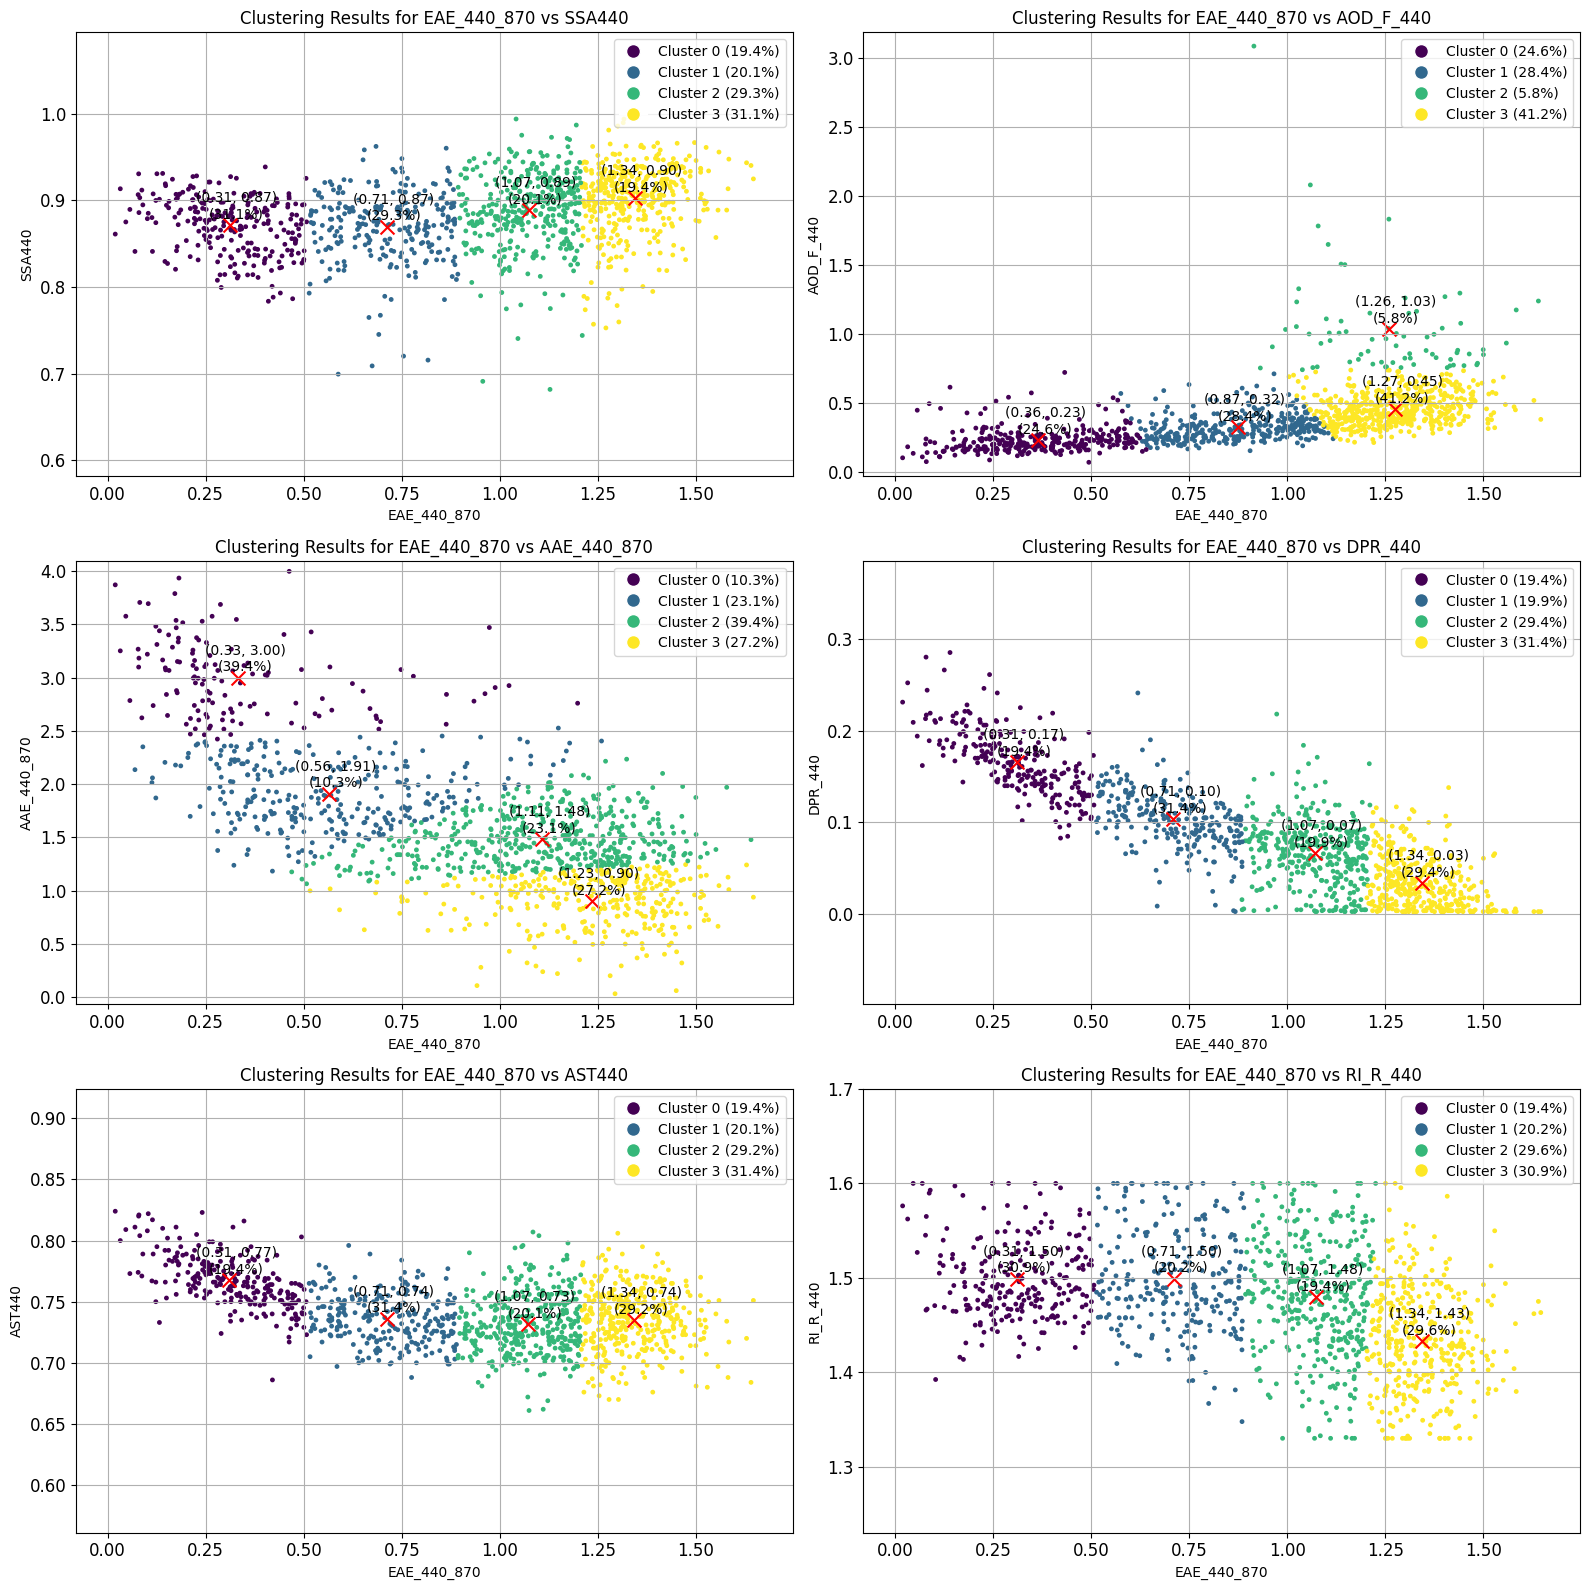

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Load the data
original_data = pd.read_csv("/content/drive/MyDrive/Clustering_data/ Cairo_EMA_2-inver_op.csv", delimiter=",")

# Define the list of feature pairs
feature_pairs = [
    ('EAE_440_870', 'SSA440'),
    ('EAE_440_870', 'AOD_F_440'),
    ('EAE_440_870', 'AAE_440_870'),
    ('EAE_440_870', 'DPR_440'),
    ('EAE_440_870', 'AST440'),
    ('EAE_440_870', 'RI_R_440')
]

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()

# Define a colormap for consistent colors
colors = plt.cm.viridis(np.linspace(0, 1, 4))

# Function to calculate cluster percentages
def calculate_cluster_percentages(labels):
    unique_clusters, counts = np.unique(labels, return_counts=True)
    total_points = len(labels)
    percentages = (counts / total_points) * 100
    return dict(zip(unique_clusters, percentages))

# Function to handle empty clusters
def handle_empty_clusters(kmeans, X, num_clusters):
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    unique_labels = np.unique(labels)
    if len(unique_labels) < num_clusters:
        for i in range(num_clusters):
            if i not in unique_labels:
                # Find the closest existing centroid
                closest_centroid = np.argmin(pairwise_distances_argmin_min(centroids, centroids)[0])
                # Assign all points to the nearest existing centroid
                labels[labels == i] = closest_centroid
        kmeans.labels_ = labels
        centroids = kmeans.cluster_centers_
    return centroids, labels

# Function to reorder clusters based on the mean value of the EAE feature
def reorder_clusters_by_eae(centroids, labels, X, feature):
    # Calculate the mean value of EAE for each cluster
    cluster_mean_values = []
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            cluster_mean = cluster_points[feature].mean()
            cluster_mean_values.append((i, cluster_mean))

    # Sort clusters by the mean value of the EAE feature
    cluster_mean_values.sort(key=lambda x: x[1])

    # Create a mapping from old label to new label
    label_mapping = {old_label: new_label for new_label, (old_label, _) in enumerate(cluster_mean_values)}

    # Reassign labels based on the new order
    new_labels = np.array([label_mapping[label] for label in labels])
    new_centroids = centroids[[label_mapping[i] for i in range(len(centroids))]]

    return new_centroids, new_labels

# Perform clustering on each feature pair
for i, (feature_x, feature_y) in enumerate(feature_pairs):
    # Ensure numeric data
    original_data[feature_x] = pd.to_numeric(original_data[feature_x], errors='coerce')
    original_data[feature_y] = pd.to_numeric(original_data[feature_y], errors='coerce')

    # Extract features and drop rows with non-numeric values
    X = original_data[[feature_x, feature_y]].dropna()

    # Perform KMeans clustering on the selected features
    num_clusters = 4
    kmeans = KMeans(n_clusters=num_clusters, random_state=2)
    kmeans.fit(X)

    # Handle empty clusters
    centroids, labels = handle_empty_clusters(kmeans, X, num_clusters)

    # Reorder clusters based on the mean value of EAE
    centroids, labels = reorder_clusters_by_eae(centroids, labels, X, 'EAE_440_870')

    # Calculate cluster percentages
    cluster_percentages = calculate_cluster_percentages(labels)

    # Visualization with consistent colors
    scatter = axes[i].scatter(X[feature_x], X[feature_y], c=labels, s=6, cmap='viridis')
    axes[i].scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroids')

    # Annotate centroids with values and percentages
    for j, (cx, cy) in enumerate(centroids):
        percentage = cluster_percentages.get(j, 0)
        axes[i].annotate(f'({cx:.2f}, {cy:.2f})\n({percentage:.1f}%)', (cx, cy), textcoords='offset points', xytext=(5, 5), ha='center')

    # Improve the readability of axis labels
    axes[i].tick_params(axis='both', labelsize=12)

    # Set axis limits for better visibility
    axes[i].set_xlim(X[feature_x].min() - 0.1, X[feature_x].max() + 0.1)
    axes[i].set_ylim(X[feature_y].min() - 0.1, X[feature_y].max() + 0.1)

    # Set title and labels
    axes[i].set_title(f'Clustering Results for {feature_x} vs {feature_y}')
    axes[i].set_xlabel(feature_x)
    axes[i].set_ylabel(feature_y)

    # Create a legend with percentages
    legend_labels = [f'Cluster {label} ({cluster_percentages.get(label, 0):.1f}%)' for label in range(num_clusters)]
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10) for label in range(num_clusters)]
    axes[i].legend(handles, legend_labels, loc='upper right')

    axes[i].grid(True)

    # Print centroid values and percentages
    print(f"\nCentroid Values and Percentages for {feature_x} vs {feature_y}:")
    for j, (cx, cy) in enumerate(centroids):
        percentage = cluster_percentages.get(j, 0)
        print(f"Cluster {j}: Centroid ({cx:.2f}, {cy:.2f}) - {percentage:.1f}% of data points")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Centroid Values and Percentages for EAE_440_870 vs SSA440:
Cluster 0: Centroid (1.47, 0.89) - 46.7% of data points
Cluster 1: Centroid (1.66, 0.89) - 26.7% of data points
Cluster 2: Centroid (1.11, 0.91) - 20.0% of data points
Cluster 3: Centroid (0.39, 0.93) - 6.7% of data points

Centroid Values and Percentages for EAE_440_870 vs AOD_F_440:
Cluster 0: Centroid (1.51, 0.72) - 33.3% of data points
Cluster 1: Centroid (1.61, 0.45) - 33.3% of data points
Cluster 2: Centroid (1.17, 0.33) - 26.7% of data points
Cluster 3: Centroid (0.39, 0.18) - 6.7% of data points

Centroid Values and Percentages for EAE_440_870 vs AAE_440_870:
Cluster 0: Centroid (1.53, 1.51) - 73.3% of data points
Cluster 1: Centroid (1.06, 2.17) - 13.3% of data points
Cluster 2: Centroid (0.39, 3.38) - 6.7% of data points
Cluster 3: Centroid (1.33, 0.74) - 6.7% of data points


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Centroid Values and Percentages for EAE_440_870 vs DPR_440:
Cluster 0: Centroid (1.47, 0.01) - 46.7% of data points
Cluster 1: Centroid (1.66, 0.00) - 26.7% of data points
Cluster 2: Centroid (1.11, 0.07) - 20.0% of data points
Cluster 3: Centroid (0.39, 0.17) - 6.7% of data points

Centroid Values and Percentages for EAE_440_870 vs AST440:
Cluster 0: Centroid (1.47, 0.69) - 46.7% of data points
Cluster 1: Centroid (1.66, 0.68) - 26.7% of data points
Cluster 2: Centroid (1.11, 0.70) - 20.0% of data points
Cluster 3: Centroid (0.39, 0.74) - 6.7% of data points

Centroid Values and Percentages for EAE_440_870 vs RI_R_440:
Cluster 0: Centroid (1.45, 1.46) - 40.0% of data points
Cluster 1: Centroid (1.64, 1.39) - 33.3% of data points
Cluster 2: Centroid (1.11, 1.46) - 20.0% of data points
Cluster 3: Centroid (0.39, 1.44) - 6.7% of data points


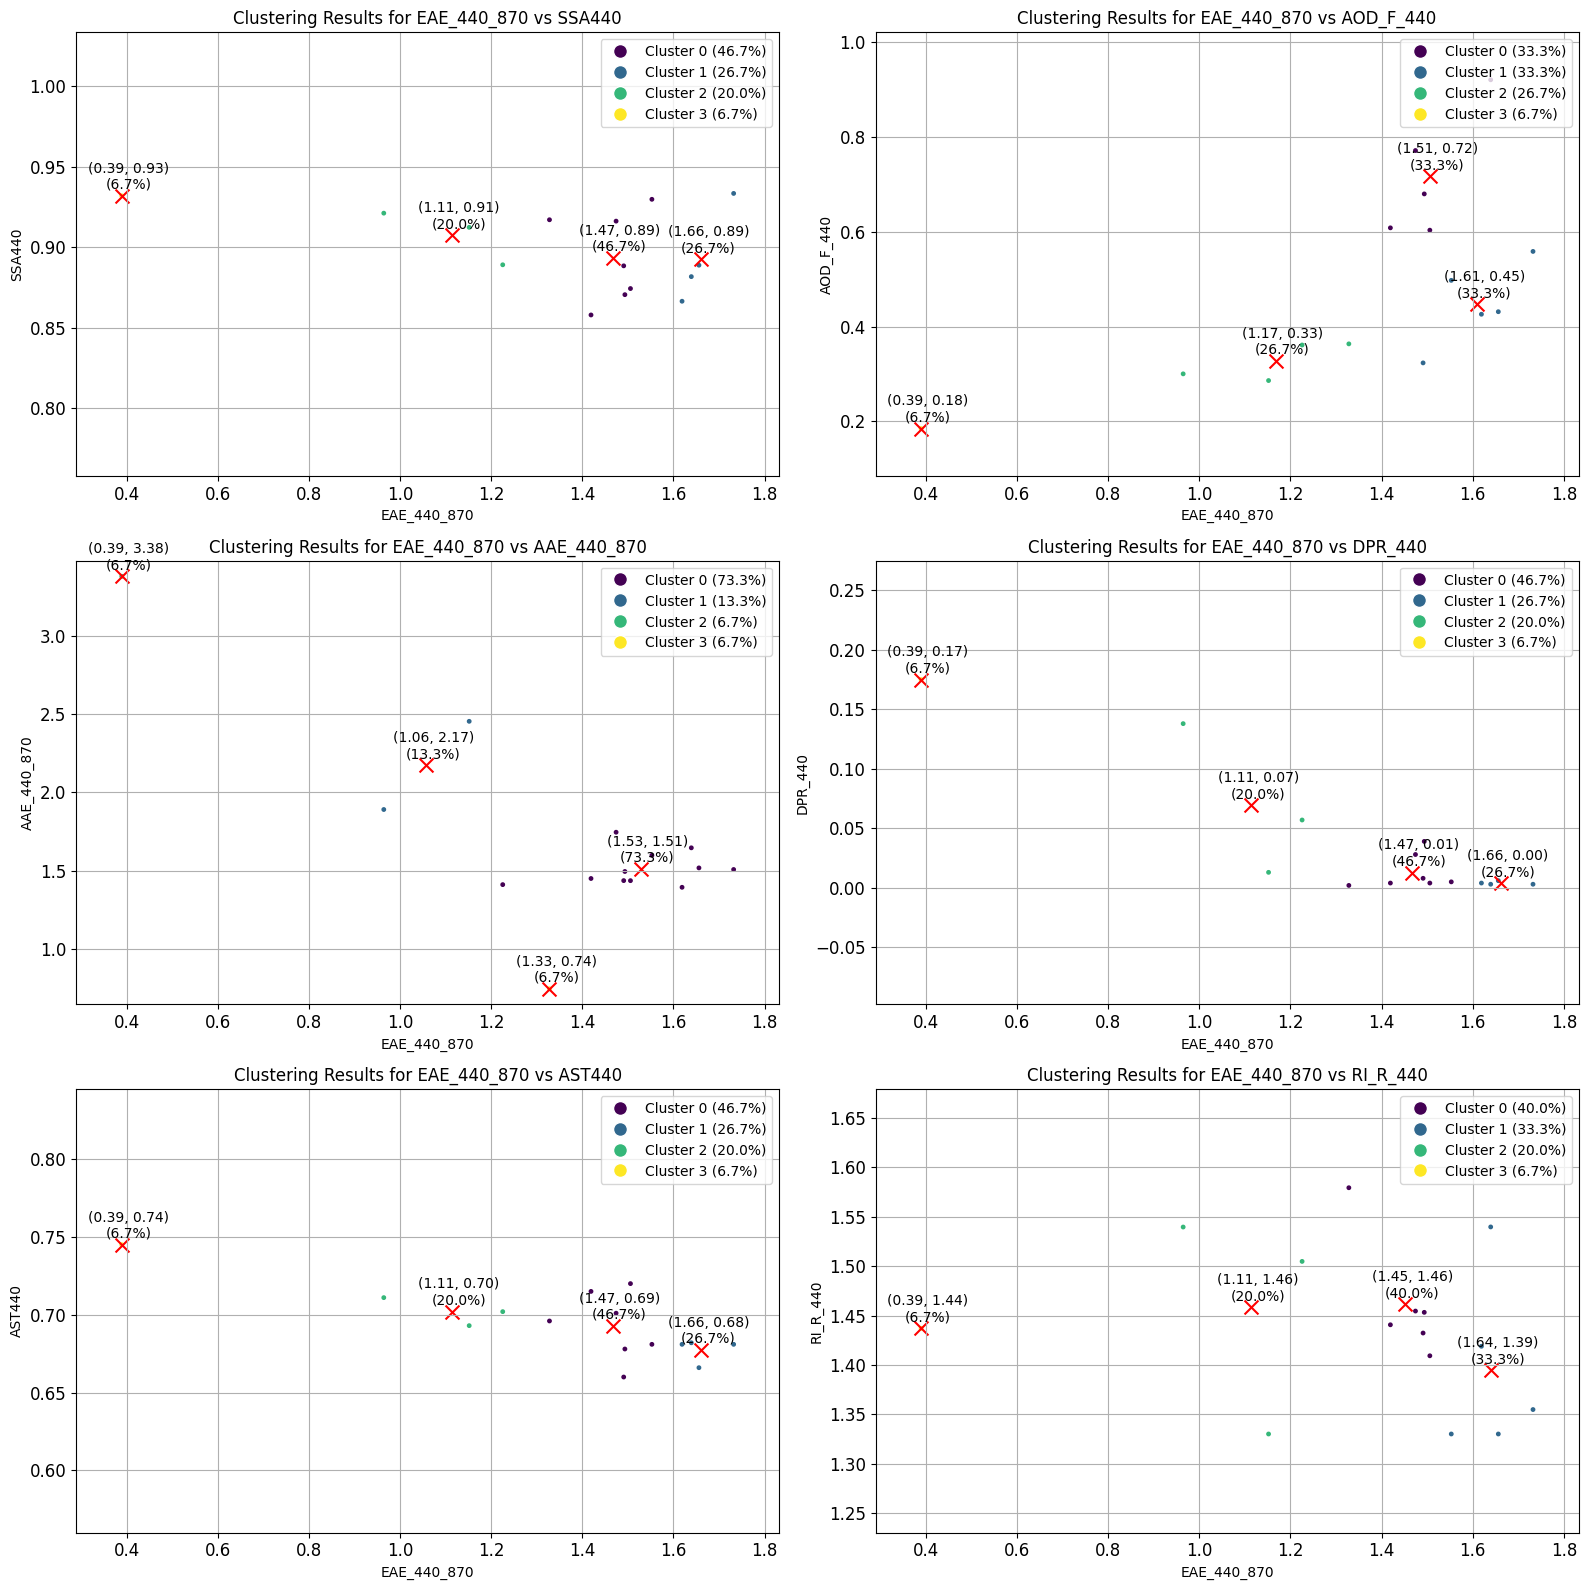

In [ ]:
#DAKAR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Load the data
original_data = pd.read_csv("/content/drive/MyDrive/Results-Africa/Henties_Bay-inver_op.csv", delimiter=",")

# Define the list of feature pairs
feature_pairs = [
    ('EAE_440_870', 'SSA440'),
    ('EAE_440_870', 'AOD_F_440'),
    ('EAE_440_870', 'AAE_440_870'),
    ('EAE_440_870', 'DPR_440'),
    ('EAE_440_870', 'AST440'),
    ('EAE_440_870', 'RI_R_440')
]

# Create a 4x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()

# Define a colormap for consistent colors
colors = plt.cm.viridis(np.linspace(0, 1, 4))
cluster_predictions=('/content/drive/MyDrive/Calculated_data17/Henties_Bay-inver_op/cluster_prediction.csv')

# Function to calculate cluster percentages
def calculate_cluster_percentages(cluster_predictions):
    unique_clusters, counts = np.unique(cluster_predictions, return_counts=True)
    total_points = len(cluster_predictions)
    percentages = (counts / total_points) * 100
    return dict(zip(unique_clusters, percentages))

# Function to handle empty clusters
def handle_empty_clusters(kmeans, X, num_clusters):
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    unique_labels = np.unique(labels)
    if len(unique_labels) < num_clusters:
        # If there are empty clusters, reassign to nearest cluster
        distances = pairwise_distances_argmin_min(centroids, centroids)
        for i in range(num_clusters):
            if i not in unique_labels:
                # Find the closest existing centroid
                closest_centroid = np.argmin(distances[0])
                # Assign all points to the nearest existing centroid
                labels[labels == i] = closest_centroid
        kmeans.labels_ = labels
        centroids = kmeans.cluster_centers_
    return centroids, labels

# Function to reorder clusters based on percentage
def reorder_clusters(centroids, labels):
    percentages = calculate_cluster_percentages(labels)
    sorted_clusters = sorted(percentages.items(), key=lambda x: -x[1])  # Sort by percentage, descending
    cluster_order = [cluster for cluster, _ in sorted_clusters]

    # Create a mapping from old label to new label
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(cluster_order)}

    # Reassign labels based on the new order
    new_labels = np.array([label_mapping[label] for label in labels])
    new_centroids = centroids[cluster_order]

    return new_centroids, new_labels

# Perform clustering on each feature pair
for i, (feature_x, feature_y) in enumerate(feature_pairs):
    # Ensure numeric data
    original_data[feature_x] = pd.to_numeric(original_data[feature_x], errors='coerce')
    original_data[feature_y] = pd.to_numeric(original_data[feature_y], errors='coerce')

    # Extract features and drop rows with non-numeric values
    X = original_data[[feature_x, feature_y]].dropna()

    # Perform KMeans clustering on the selected features
    num_clusters = 4  # Adjust the number of clusters as needed
    kmeans = KMeans(n_clusters=num_clusters, random_state=2)
    kmeans.fit(X)

    # Handle empty clusters
    centroids, labels = handle_empty_clusters(kmeans, X, num_clusters)

    # Reorder clusters based on percentage
    centroids, labels = reorder_clusters(centroids, labels)

    # Calculate cluster percentages
    cluster_percentages = calculate_cluster_percentages(labels)

    # Visualization with consistent colors
    scatter = axes[i].scatter(X[feature_x], X[feature_y], c=labels, s=6, cmap='viridis')
    axes[i].scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroids')

    # Annotate centroids with values and percentages
    for j, (cx, cy) in enumerate(centroids):
        percentage = cluster_percentages.get(j, 0)
        axes[i].annotate(f'({cx:.2f}, {cy:.2f})\n({percentage:.1f}%)', (cx, cy), textcoords='offset points', xytext=(5,5), ha='center')

    # Improve the readability of axis labels
    axes[i].tick_params(axis='both', labelsize=12)

    # Set axis limits for better visibility
    axes[i].set_xlim(X[feature_x].min() - 0.1, X[feature_x].max() + 0.1)
    axes[i].set_ylim(X[feature_y].min() - 0.1, X[feature_y].max() + 0.1)

    # Set title and labels
    axes[i].set_title(f'Clustering Results for {feature_x} vs {feature_y}')
    axes[i].set_xlabel(feature_x)
    axes[i].set_ylabel(feature_y)

    # Create a legend with percentages
    legend_labels = [f'Cluster {label} ({cluster_percentages.get(label, 0):.1f}%)' for label in range(num_clusters)]
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10) for label in range(num_clusters)]
    axes[i].legend(handles, legend_labels, loc='upper right')

    axes[i].grid(True)

        # Print centroid values and percentages
    print(f"\nCentroid Values and Percentages for {feature_x} vs {feature_y}:")
    for j, (cx, cy) in enumerate(centroids):
        percentage = cluster_percentages.get(j, 0)
        print(f"Cluster {j}: Centroid ({cx:.2f}, {cy:.2f}) - {percentage:.1f}% of data points")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

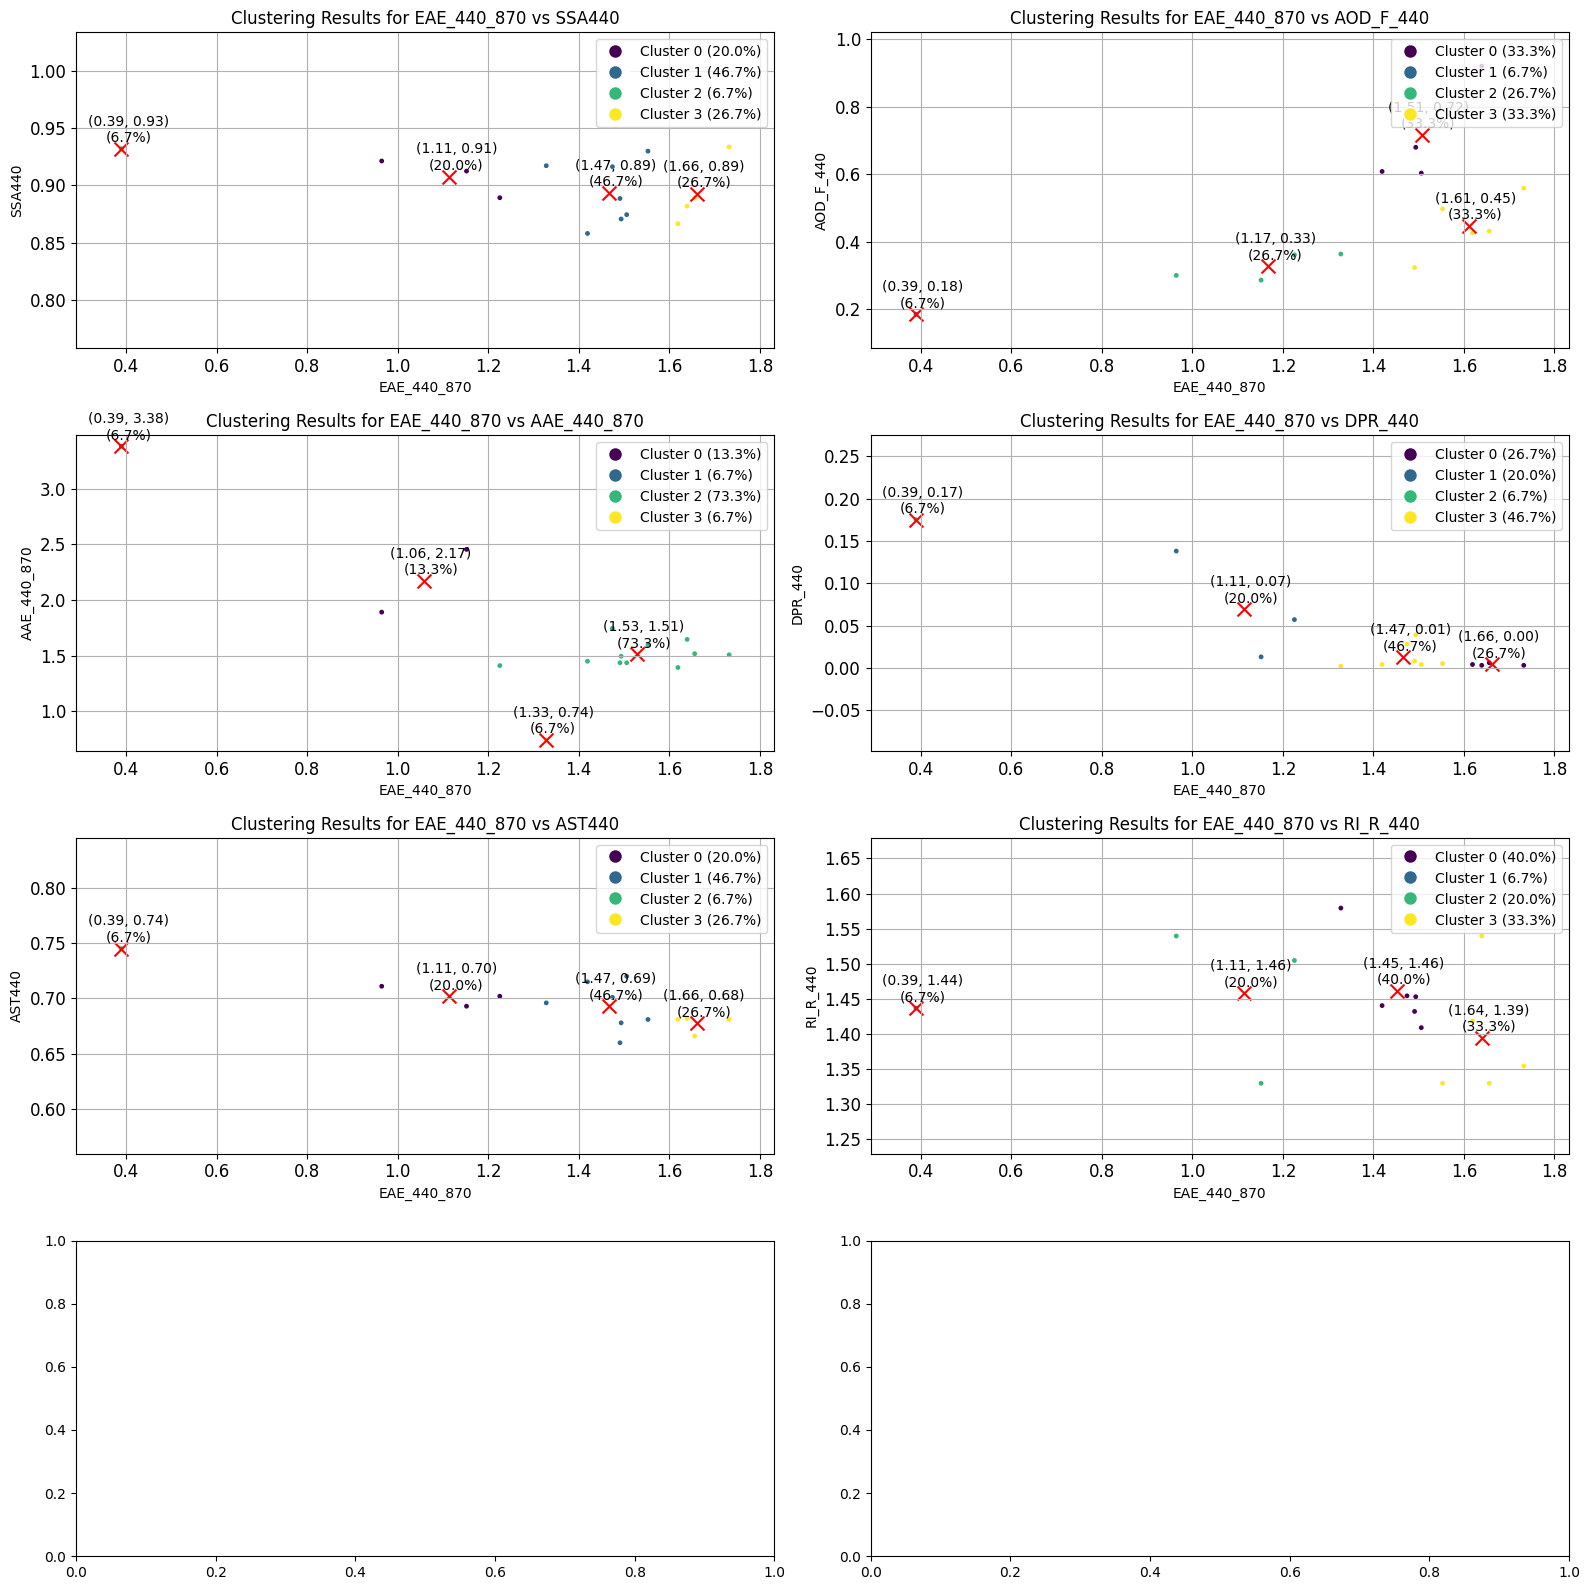

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the data
original_data = pd.read_csv("/content/drive/MyDrive/Results-Africa/Henties_Bay-inver_op.csv", delimiter=",")

# Define the list of feature pairs
feature_pairs = [
    ('EAE_440_870', 'SSA440'),
    ('EAE_440_870', 'AOD_F_440'),
    ('EAE_440_870', 'AAE_440_870'),
    ('EAE_440_870', 'DPR_440'),
    ('EAE_440_870', 'AST440'),
    ('EAE_440_870', 'RI_R_440')
]

# Create a 4x2 grid of subplots
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

# Define a colormap for consistent colors
colors = plt.cm.viridis(np.linspace(0, 1, 4))
cluster_predictions=('/content/drive/MyDrive/Calculated_data17/Henties_Bay-inver_op/cluster_prediction.csv')

# Function to calculate cluster percentages
def calculate_cluster_percentages(cluster_predictions):
    unique_clusters, counts = np.unique(cluster_predictions, return_counts=True)
    total_points = len(cluster_predictions)
    percentages = (counts / total_points) * 100
    return dict(zip(unique_clusters, percentages))

# Function to handle empty clusters
def handle_empty_clusters(kmeans, X, num_clusters):
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    unique_labels = np.unique(labels)
    if len(unique_labels) < num_clusters:
        # If there are empty clusters, reassign to nearest cluster
        distances = pairwise_distances_argmin_min(centroids, centroids)
        for i in range(num_clusters):
            if i not in unique_labels:
                # Find the closest existing centroid
                closest_centroid = np.argmin(distances[0])
                # Assign all points to the nearest existing centroid
                labels[labels == i] = closest_centroid
        kmeans.labels_ = labels
        centroids = kmeans.cluster_centers_
    return centroids, labels

# Perform clustering on each feature pair
for i, (feature_x, feature_y) in enumerate(feature_pairs):
    # Ensure numeric data
    original_data[feature_x] = pd.to_numeric(original_data[feature_x], errors='coerce')
    original_data[feature_y] = pd.to_numeric(original_data[feature_y], errors='coerce')

    # Extract features and drop rows with non-numeric values
    X = original_data[[feature_x, feature_y]].dropna()

    # Perform KMeans clustering on the selected features
    num_clusters = 4  # Adjust the number of clusters as needed
    kmeans = KMeans(n_clusters=num_clusters, random_state=2)
    kmeans.fit(X)

    # Handle empty clusters
    centroids, labels = handle_empty_clusters(kmeans, X, num_clusters)

    # Calculate cluster percentages
    cluster_percentages = calculate_cluster_percentages(labels)

    # Visualization with consistent colors
    scatter = axes[i].scatter(X[feature_x], X[feature_y], c=labels, s=6, cmap='viridis')
    axes[i].scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red', label='Centroids')

    # Annotate centroids with values and percentages
    for j, (cx, cy) in enumerate(centroids):
        percentage = cluster_percentages.get(j, 0)
        axes[i].annotate(f'({cx:.2f}, {cy:.2f})\n({percentage:.1f}%)', (cx, cy), textcoords='offset points', xytext=(5,5), ha='center')

    # Improve the readability of axis labels
    axes[i].tick_params(axis='both', labelsize=12)

    # Set axis limits for better visibility
    axes[i].set_xlim(X[feature_x].min() - 0.1, X[feature_x].max() + 0.1)
    axes[i].set_ylim(X[feature_y].min() - 0.1, X[feature_y].max() + 0.1)

    # Set title and labels
    axes[i].set_title(f'Clustering Results for {feature_x} vs {feature_y}')
    axes[i].set_xlabel(feature_x)
    axes[i].set_ylabel(feature_y)

    # Create a legend with percentages
    legend_labels = [f'Cluster {label} ({cluster_percentages.get(label, 0):.1f}%)' for label in range(num_clusters)]
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10) for label in range(num_clusters)]
    axes[i].legend(handles, legend_labels, loc='upper right')

    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Convert AOD_F_440 to numeric
original_data['AOD_F_440'] = pd.to_numeric(original_data['AOD_F_440'], errors='coerce')

# Check again for missing values after conversion
missing_values = original_data['AOD_F_440'].isna().sum()
print(f"Missing values in AOD_F_440 after conversion: {missing_values}")

# Re-run the descriptive statistics to check the correct range
print("Corrected summary statistics for AOD_F_440:")
print(original_data['AOD_F_440'].describe())


Missing values in AOD_F_440 after conversion: 1
Corrected summary statistics for AOD_F_440:
count    435.000000
mean       0.204072
std        0.075768
min        0.087030
25%        0.152475
50%        0.183350
75%        0.232850
max        0.532400
Name: AOD_F_440, dtype: float64


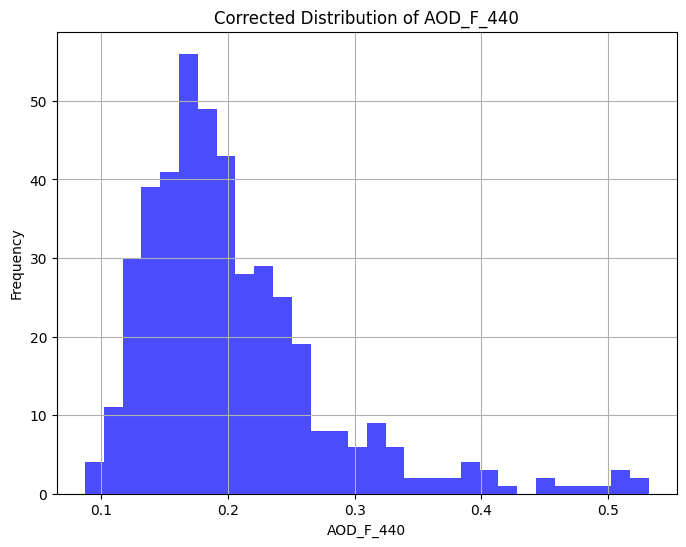

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(original_data['AOD_F_440'].dropna(), bins=30, color='blue', alpha=0.7)
plt.xlabel('AOD_F_440')
plt.ylabel('Frequency')
plt.title('Corrected Distribution of AOD_F_440')
plt.grid(True)
plt.show()
